In [6]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [7]:
# Check the number of unique classes in your training labels



In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Add, BatchNormalization
import tensorflow as tf

# Load TRAIN and TEST data from .xlsx files
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAIN.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TEST.xlsx")

# Extract features and labels from train and test data
X_train = trainData.drop(columns=['Genre', 'File Name']).values  # Exclude 'Genre' and 'File Name' columns
y_train = trainData['Genre'].values

X_test = testData.drop(columns=['Genre', 'File Name']).values
y_test = testData['Genre'].values

# Encode labels (Genre) into numerical form
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encode the labels
y_train_onehot = to_categorical(y_train_encoded, num_classes=20)  # Assuming 10 subgenres
y_test_onehot = to_categorical(y_test_encoded, num_classes=20)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape input data to be compatible with Conv1D (samples, timesteps, features)
X_train_scaled = np.expand_dims(X_train_scaled, axis=-1)  # Shape (samples, timesteps, 1)
X_test_scaled = np.expand_dims(X_test_scaled, axis=-1)

# Define the ResNet block
def resnet_block(input_layer, filters, kernel_size=3, strides=1):
    # First convolutional layer
    conv1 = Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation=None)(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = tf.keras.activations.relu(conv1)

    # Second convolutional layer
    conv2 = Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation=None)(conv1)
    conv2 = BatchNormalization()(conv2)

    # Adjust the shortcut (input) to match the number of filters in the conv2 output using 1x1 convolution
    shortcut = Conv1D(filters=filters, kernel_size=1, strides=strides, padding='same', activation=None)(input_layer)
    shortcut = BatchNormalization()(shortcut)

    # Add the shortcut to the output of the second convolutional layer
    output_layer = Add()([shortcut, conv2])

    # Apply ReLU activation
    return tf.keras.activations.relu(output_layer)


# Input Layer (68 features, reshaped to be compatible with Conv1D)
input_layer = Input(shape=(68, 1))  # Input with 68 features

# Layer 1: Conv1D -> ResNet Block -> MaxPooling
x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(input_layer)
x = BatchNormalization()(x)
x = resnet_block(x, 128)
x = MaxPooling1D(pool_size=3, strides=3)(x)

# Layer 2: ResNet Block -> MaxPooling
x = resnet_block(x, 128)
x = MaxPooling1D(pool_size=3, strides=3)(x)

# Layer 3: ResNet Block -> MaxPooling
x = resnet_block(x, 256)
x = MaxPooling1D(pool_size=3, strides=3)(x)

# Layer 4: ResNet Block -> MaxPooling
x = resnet_block(x, 256)
x = MaxPooling1D(pool_size=3, strides=3)(x)

# Layer 5: ResNet Block -> MaxPooling
x = resnet_block(x, 256)
x = MaxPooling1D(pool_size=3, strides=3)(x)

# Layer 6: ResNet Block -> MaxPooling
x = resnet_block(x, 256)
x = MaxPooling1D(pool_size=3, strides=3)(x)

# Layer 7: Conv1D -> MaxPooling
x = Conv1D(512, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=3, strides=3)(x)

# Global Average Pooling and Output Layer
x = GlobalAveragePooling1D()(x)
output_layer = Dense(10, activation='softmax')(x)  # Assuming 10 classes for subgenres

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train_onehot, epochs=30, batch_size=32, validation_data=(X_test_scaled, y_test_onehot))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test_onehot)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


Epoch 1/30


ValueError: Exception encountered when calling MaxPooling1D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node functional_3_1/max_pooling1d_14_1/MaxPool1d}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 1, 3, 1], padding="VALID", strides=[1, 1, 3, 1]](functional_3_1/max_pooling1d_14_1/MaxPool1d/ExpandDims)' with input shapes: [?,1,2,256].[0m

Arguments received by MaxPooling1D.call():
  • inputs=tf.Tensor(shape=(None, 2, 256), dtype=float32)

Epoch 1/100


c:\Users\ashut\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.1063 - loss: 5.2459 - val_accuracy: 0.0594 - val_loss: 4.8843 - learning_rate: 0.0010
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1524 - loss: 4.8535 - val_accuracy: 0.0750 - val_loss: 5.1421 - learning_rate: 0.0010
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1774 - loss: 4.6038 - val_accuracy: 0.0406 - val_loss: 5.4181 - learning_rate: 0.0010
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2154 - loss: 4.3423 - val_accuracy: 0.0250 - val_loss: 5.8094 - learning_rate: 0.0010
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2862 - loss: 4.1297 - val_accuracy: 0.0531 - val_loss: 5.3707 - learning_rate: 0.0010
Epoch 6/100
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3279 - loss: 3.9683
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3271 - loss: 3.9713 - val_accuracy:

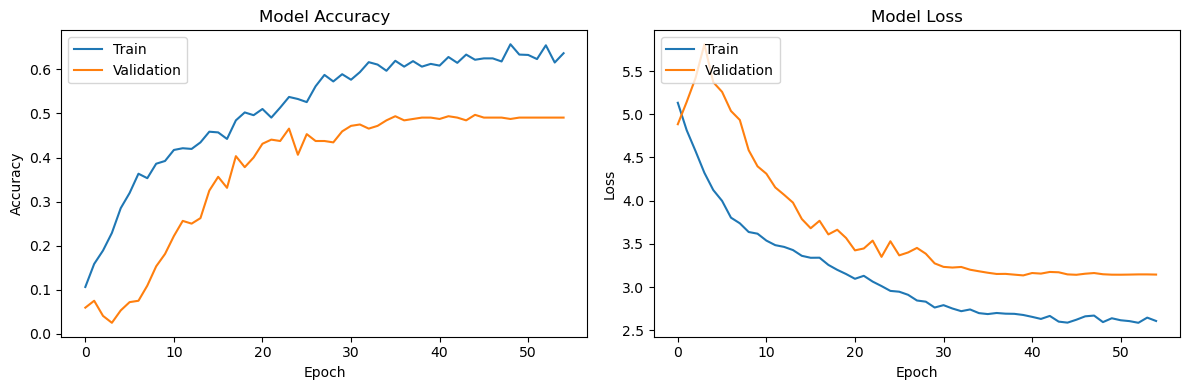

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Add,
    BatchNormalization, Dropout, LeakyReLU, Activation, concatenate
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load and preprocess data
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAIN.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TEST.xlsx")

# Extract features and labels
X = pd.concat([
    trainData.drop(columns=['Genre', 'File Name']),
    testData.drop(columns=['Genre', 'File Name'])
])
y = pd.concat([trainData['Genre'], testData['Genre']])

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded, num_classes=20)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.expand_dims(X_scaled, axis=-1)

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

def inception_module(input_layer, filters):
    # 1x1 convolution
    conv1 = Conv1D(filters, 1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    
    # 3x3 convolution
    conv3 = Conv1D(filters, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    
    # 5x5 convolution
    conv5 = Conv1D(filters, 5, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    
    # Concatenate all branches
    concat = concatenate([conv1, conv3, conv5], axis=-1)
    return concat

def resnet_block(input_layer, filters, kernel_size=3):
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv1D(filters, 1, padding='same')(input_layer)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([shortcut, x])
    return LeakyReLU(alpha=0.2)(x)

# Input Layer
input_layer = Input(shape=(68, 1))

# First Block: Inception Module
x = inception_module(input_layer, 64)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)

# Second Block: ResNet
x = resnet_block(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)

# Third Block: Inception Module
x = inception_module(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)

# Fourth Block: ResNet
x = resnet_block(x, 256)
x = Dropout(0.3)(x)

# Fifth Block: Dense Layers
x = GlobalAveragePooling1D()(x)
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

x = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

# Output Layer
output_layer = Dense(20, activation='softmax')(x)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile with fixed learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Calculate class weights
class_counts = np.sum(y_train, axis=0)
total_samples = np.sum(class_counts)
class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight,
    shuffle=True
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Key changes made to fix the dimensionality issue:

Reduced the number of MaxPooling layers to prevent the sequence length from becoming too small
Changed pool_size and strides from 3 to 2 to reduce the rate at which the sequence length decreases
Maintained the essential ResNet structure but with fewer blocks
Kept the filter progression (128 -> 256 -> 512) but with fewer stages
Added proper padding in the Conv1D layers to maintain dimensions
Simplified the architecture while maintaining the key ResNet characteristics

The network should now work with your input shape (68, 1) while still capturing the essential elements of the ResNet architecture.

Epoch 1/100


c:\Users\ashut\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.0789 - loss: 5.2829 - val_accuracy: 0.0700 - val_loss: 4.9327 - learning_rate: 0.0010
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1561 - loss: 4.7650 - val_accuracy: 0.0500 - val_loss: 5.1894 - learning_rate: 0.0010
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2333 - loss: 4.4367 - val_accuracy: 0.0500 - val_loss: 5.4489 - learning_rate: 0.0010
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2430 - loss: 4.2766 - val_accuracy: 0.0500 - val_loss: 5.9685 - learning_rate: 0.0010
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2973 - loss: 4.0569 - val_accuracy: 0.0650 - val_loss: 5.3439 - learning_rate: 0.0010
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3409 - loss: 3.7953 - val_accuracy: 0.1025 - val_loss: 4.8225 - learning_rate: 0.0010
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3840 - loss: 3.6616 - val_accuracy

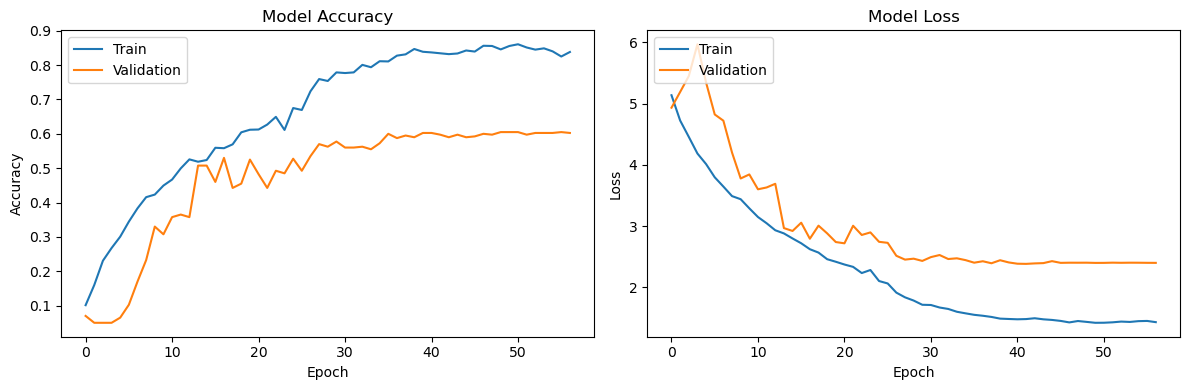

In [ ]:
'''

there is more diffrence

'''

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Add,
    BatchNormalization, Dropout, LeakyReLU, Activation, concatenate
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load and preprocess data
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAIN.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TEST.xlsx")

# Extract features and labels
X = pd.concat([
    trainData.drop(columns=['Genre', 'File Name']),
    testData.drop(columns=['Genre', 'File Name'])
])
y = pd.concat([trainData['Genre'], testData['Genre']])

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded, num_classes=20)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.expand_dims(X_scaled, axis=-1)

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

def inception_module(input_layer, filters):
    # 1x1 convolution
    conv1 = Conv1D(filters, 1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    
    # 3x3 convolution
    conv3 = Conv1D(filters, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    
    # 5x5 convolution
    conv5 = Conv1D(filters, 5, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    
    # Concatenate all branches
    concat = concatenate([conv1, conv3, conv5], axis=-1)
    return concat

def resnet_block(input_layer, filters, kernel_size=3):
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv1D(filters, 1, padding='same')(input_layer)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([shortcut, x])
    return LeakyReLU(alpha=0.2)(x)

# Input Layer
input_layer = Input(shape=(68, 1))

# First Block: Inception Module
x = inception_module(input_layer, 64)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)

# Second Block: ResNet
x = resnet_block(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)

# Third Block: Inception Module
x = inception_module(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)

# Fourth Block: ResNet
x = resnet_block(x, 256)
x = Dropout(0.3)(x)

# Fifth Block: Dense Layers
x = GlobalAveragePooling1D()(x)
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

x = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

# Output Layer
output_layer = Dense(20, activation='softmax')(x)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile with fixed learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Calculate class weights
class_counts = np.sum(y_train, axis=0)
total_samples = np.sum(class_counts)
class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight,
    shuffle=True
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

c:\Users\ashut\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
C:\Users\ashut\AppData\Local\Temp\ipykernel_40036\1950065242.py:146: RuntimeWarning: divide by zero encountered in divide
  class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))


Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.2648 - loss: 2.8188 - val_accuracy: 0.4036 - val_loss: 2.4801 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.4595 - loss: 1.4938 - val_accuracy: 0.4894 - val_loss: 1.8703 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.4872 - loss: 1.0785 - val_accuracy: 0.5042 - val_loss: 1.6887 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5015 - loss: 0.9628 - val_accuracy: 0.4954 - val_loss: 1.6928 - learning_rate: 0.0010
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.4997 - loss: 0.9366 - val_accuracy: 0.4582 - val_loss: 1.8273 - learning_rate: 0.0010
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5085 - loss: 0.9299 - val_accuracy: 0.5146 - val_loss: 1.5866 - learning_rate: 0.0010
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5

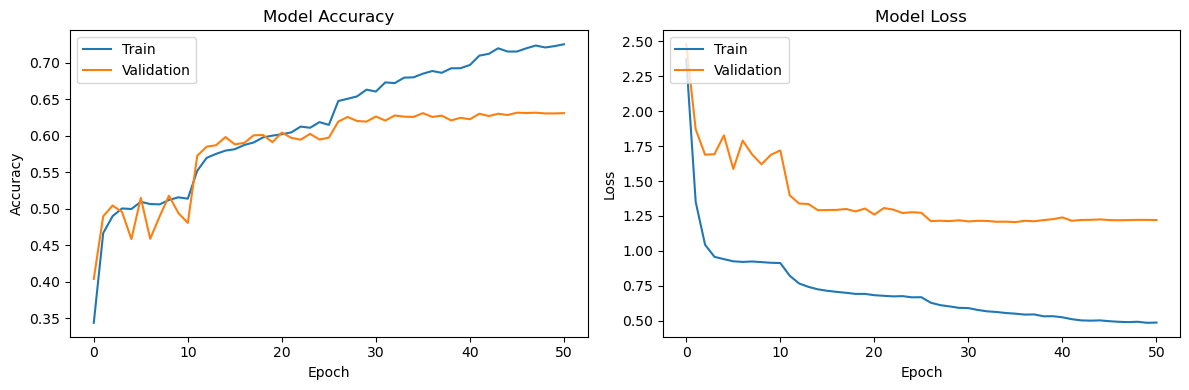

In [1]:
'''

there is more diffrence

'''

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Add,
    BatchNormalization, Dropout, LeakyReLU, Activation, concatenate
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load and preprocess data
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\FinalTRAIN.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\FinalTEST.xlsx")

# Extract features and labels
X = pd.concat([
    trainData.drop(columns=['Genre', 'File Name']),
    testData.drop(columns=['Genre', 'File Name'])
])
y = pd.concat([trainData['Genre'], testData['Genre']])

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded, num_classes=20)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.expand_dims(X_scaled, axis=-1)

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

def inception_module(input_layer, filters):
    # 1x1 convolution
    conv1 = Conv1D(filters, 1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    
    # 3x3 convolution
    conv3 = Conv1D(filters, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    
    # 5x5 convolution
    conv5 = Conv1D(filters, 5, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    
    # Concatenate all branches
    concat = concatenate([conv1, conv3, conv5], axis=-1)
    return concat

def resnet_block(input_layer, filters, kernel_size=3):
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv1D(filters, 1, padding='same')(input_layer)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([shortcut, x])
    return LeakyReLU(alpha=0.2)(x)

# Input Layer
input_layer = Input(shape=(68, 1))

# First Block: Inception Module
x = inception_module(input_layer, 64)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)

# Second Block: ResNet
x = resnet_block(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)

# Third Block: Inception Module
x = inception_module(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)

# Fourth Block: ResNet
x = resnet_block(x, 256)
x = Dropout(0.3)(x)

# Fifth Block: Dense Layers
x = GlobalAveragePooling1D()(x)
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

x = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

# Output Layer
output_layer = Dense(20, activation='softmax')(x)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile with fixed learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Calculate class weights
class_counts = np.sum(y_train, axis=0)
total_samples = np.sum(class_counts)
class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight,
    shuffle=True
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Epoch 1/100


c:\Users\ashut\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.2811 - loss: 3.9302 - val_accuracy: 0.4304 - val_loss: 2.9275 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5195 - loss: 2.5766 - val_accuracy: 0.5700 - val_loss: 2.0713 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5766 - loss: 2.0132 - val_accuracy: 0.6330 - val_loss: 1.6919 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6243 - loss: 1.6930 - val_accuracy: 0.6528 - val_loss: 1.5147 - learning_rate: 0.0010
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6519 - loss: 1.5444 - val_accuracy: 0.6906 - val_loss: 1.3991 - learning_rate: 0.0010
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6617 - loss: 1.4952 - val_accuracy: 0.7078 - val_loss: 1.3278 - learning_rate: 0.0010
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6689 - loss: 

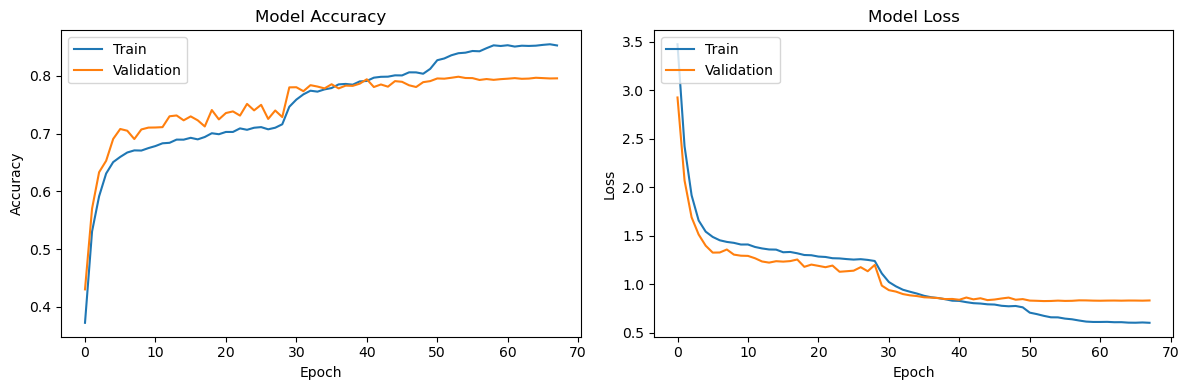

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Add,
    BatchNormalization, Dropout, LeakyReLU, concatenate
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load and preprocess data
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAINFINAL8FEATURESEXTRA_CLEANED.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TESTFINAL8FEATURESEXTRA_CLEANED.xlsx")

# Exclude specific columns
exclude_columns = ['Onsets',
                    'Harmonic Mean', 
                    'Percussive Mean',
                    'CQT Mean',
                    'Genre',
                    'File Name',
                    'Beat Sync MFCC Mean',
                    'Rhythm Complexity',	
                    #'Tempo',	
                    #'Tempogram Mean'
                    ]
# Extract features and labels, excluding specified columns
X = pd.concat([trainData.drop(columns=exclude_columns), testData.drop(columns=exclude_columns)])
y = pd.concat([trainData['Genre'], testData['Genre']])

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded, num_classes=len(label_encoder.classes_))

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.expand_dims(X_scaled, axis=-1)  # Add channel dimension

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

# Define the Inception module
def inception_module(input_layer, filters):
    conv1 = Conv1D(filters, 1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    
    conv3 = Conv1D(filters, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    
    conv5 = Conv1D(filters, 5, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    
    concat = concatenate([conv1, conv3, conv5], axis=-1)
    return concat

# Define ResNet block
def resnet_block(input_layer, filters, kernel_size=3):
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv1D(filters, 1, padding='same')(input_layer)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([shortcut, x])
    return LeakyReLU(alpha=0.2)(x)

# Model Architecture
input_layer = Input(shape=(X_scaled.shape[1], 1))  # Adjust input shape based on features
x = inception_module(input_layer, 64)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)
x = resnet_block(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)
x = inception_module(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)
x = resnet_block(x, 256)
x = Dropout(0.3)(x)

# Fully Connected Layers
x = GlobalAveragePooling1D()(x)
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

x = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

# Output Layer
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(x)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile with fixed learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Calculate class weights
class_counts = np.sum(y_train, axis=0)
total_samples = np.sum(class_counts)
class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight,
    shuffle=True
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


Epoch 1/100


c:\Users\ashut\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.2799 - loss: 3.9571 - val_accuracy: 0.4702 - val_loss: 2.8849 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5177 - loss: 2.6143 - val_accuracy: 0.5576 - val_loss: 2.1278 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5725 - loss: 2.0349 - val_accuracy: 0.6318 - val_loss: 1.6897 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6300 - loss: 1.6884 - val_accuracy: 0.6706 - val_loss: 1.5028 - learning_rate: 0.0010
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6466 - loss: 1.5534 - val_accuracy: 0.6890 - val_loss: 1.3894 - learning_rate: 0.0010
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6593 - loss: 1.4997 - val_accuracy: 0.6958 - val_loss: 1.3598 - learning_rate: 0.0010
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6669 - loss: 

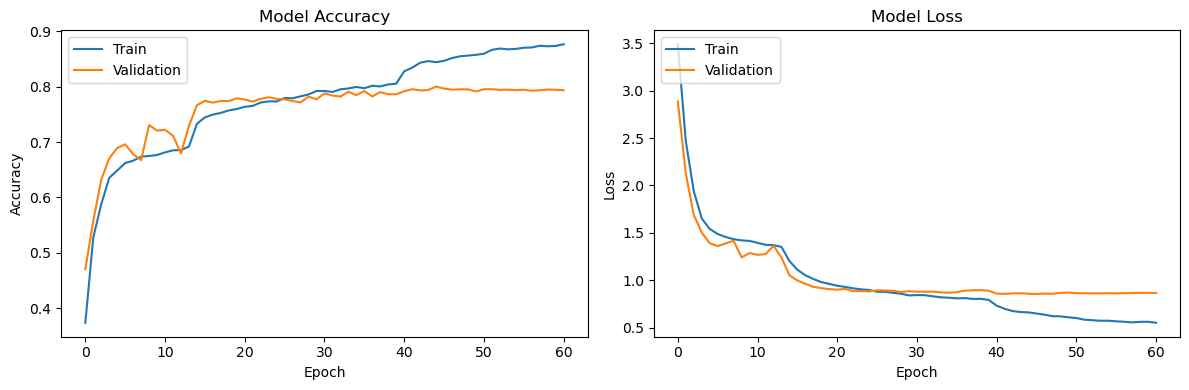

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Add,
    BatchNormalization, Dropout, LeakyReLU, concatenate
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load and preprocess data
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAINFINAL8FEATURESEXTRA_CLEANED.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TESTFINAL8FEATURESEXTRA_CLEANED.xlsx")

# Exclude specific columns
exclude_columns = ['Onsets',
                    'Harmonic Mean', 
                    'Percussive Mean',
                    #'CQT Mean',
                    'Genre',
                    'File Name',
                    'Beat Sync MFCC Mean',
                    'Rhythm Complexity',	
                    #'Tempo',	
                    #'Tempogram Mean'
                    ]
# Extract features and labels, excluding specified columns
X = pd.concat([trainData.drop(columns=exclude_columns), testData.drop(columns=exclude_columns)])
y = pd.concat([trainData['Genre'], testData['Genre']])

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded, num_classes=len(label_encoder.classes_))

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.expand_dims(X_scaled, axis=-1)  # Add channel dimension

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

# Define the Inception module
def inception_module(input_layer, filters):
    conv1 = Conv1D(filters, 1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    
    conv3 = Conv1D(filters, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    
    conv5 = Conv1D(filters, 5, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    
    concat = concatenate([conv1, conv3, conv5], axis=-1)
    return concat

# Define ResNet block
def resnet_block(input_layer, filters, kernel_size=3):
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv1D(filters, 1, padding='same')(input_layer)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([shortcut, x])
    return LeakyReLU(alpha=0.2)(x)

# Model Architecture
input_layer = Input(shape=(X_scaled.shape[1], 1))  # Adjust input shape based on features
x = inception_module(input_layer, 64)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)
x = resnet_block(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)
x = inception_module(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)
x = resnet_block(x, 256)
x = Dropout(0.3)(x)

# Fully Connected Layers
x = GlobalAveragePooling1D()(x)
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

x = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

# Output Layer
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(x)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile with fixed learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Calculate class weights
class_counts = np.sum(y_train, axis=0)
total_samples = np.sum(class_counts)
class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight,
    shuffle=True
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


Epoch 1/100


c:\Users\ashut\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.2929 - loss: 3.9037 - val_accuracy: 0.4934 - val_loss: 2.8650 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6056 - loss: 2.4247 - val_accuracy: 0.6728 - val_loss: 1.8415 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6485 - loss: 1.8448 - val_accuracy: 0.6674 - val_loss: 1.6180 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6635 - loss: 1.5985 - val_accuracy: 0.7082 - val_loss: 1.3917 - learning_rate: 0.0010
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6795 - loss: 1.4468 - val_accuracy: 0.7068 - val_loss: 1.3325 - learning_rate: 0.0010
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6835 - loss: 1.3988 - val_accuracy: 0.6832 - val_loss: 1.4067 - learning_rate: 0.0010
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6918 - loss: 

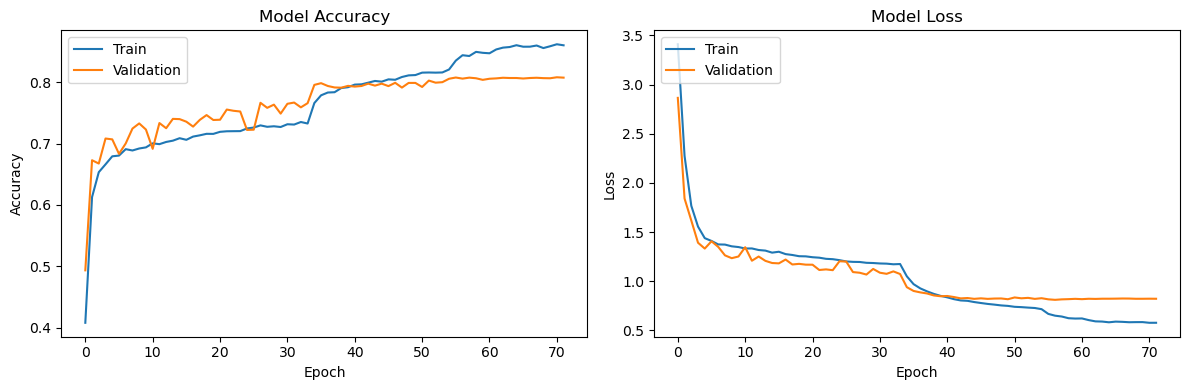

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Add,
    BatchNormalization, Dropout, LeakyReLU, concatenate
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load and preprocess data
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAINFINAL8FEATURESEXTRA_CLEANED.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TESTFINAL8FEATURESEXTRA_CLEANED.xlsx")

# Exclude specific columns
exclude_columns = ['Onsets',
                    'Harmonic Mean', 
                    #'Percussive Mean',
                    #'CQT Mean',
                    'Genre',
                    'File Name',
                    'Beat Sync MFCC Mean',
                    'Rhythm Complexity',	
                    #'Tempo',	
                    #'Tempogram Mean'
                    ]
# Extract features and labels, excluding specified columns
X = pd.concat([trainData.drop(columns=exclude_columns), testData.drop(columns=exclude_columns)])
y = pd.concat([trainData['Genre'], testData['Genre']])

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded, num_classes=len(label_encoder.classes_))

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.expand_dims(X_scaled, axis=-1)  # Add channel dimension

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

# Define the Inception module
def inception_module(input_layer, filters):
    conv1 = Conv1D(filters, 1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    
    conv3 = Conv1D(filters, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    
    conv5 = Conv1D(filters, 5, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    
    concat = concatenate([conv1, conv3, conv5], axis=-1)
    return concat

# Define ResNet block
def resnet_block(input_layer, filters, kernel_size=3):
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv1D(filters, 1, padding='same')(input_layer)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([shortcut, x])
    return LeakyReLU(alpha=0.2)(x)

# Model Architecture
input_layer = Input(shape=(X_scaled.shape[1], 1))  # Adjust input shape based on features
x = inception_module(input_layer, 64)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)
x = resnet_block(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)
x = inception_module(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)
x = resnet_block(x, 256)
x = Dropout(0.3)(x)

# Fully Connected Layers
x = GlobalAveragePooling1D()(x)
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

x = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

# Output Layer
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(x)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile with fixed learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Calculate class weights
class_counts = np.sum(y_train, axis=0)
total_samples = np.sum(class_counts)
class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight,
    shuffle=True
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


Epoch 1/100


c:\Users\ashut\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.2937 - loss: 3.9059 - val_accuracy: 0.5988 - val_loss: 2.6035 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.5992 - loss: 2.4443 - val_accuracy: 0.6492 - val_loss: 1.9375 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6555 - loss: 1.8474 - val_accuracy: 0.7074 - val_loss: 1.4917 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6675 - loss: 1.5783 - val_accuracy: 0.6638 - val_loss: 1.4797 - learning_rate: 0.0010
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6766 - loss: 1.4561 - val_accuracy: 0.7120 - val_loss: 1.3056 - learning_rate: 0.0010
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6825 - loss: 1.4004 - val_accuracy: 0.6896 - val_loss: 1.3490 - learning_rate: 0.0010
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6848 - loss: 

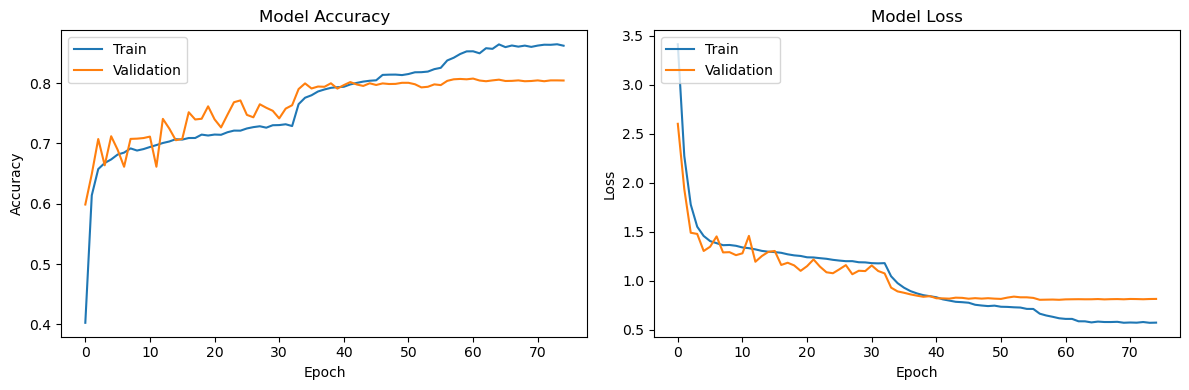

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Add,
    BatchNormalization, Dropout, LeakyReLU, concatenate
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load and preprocess data
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAINFINAL8FEATURESEXTRA_CLEANED.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TESTFINAL8FEATURESEXTRA_CLEANED.xlsx")

# Exclude specific columns
exclude_columns = ['Onsets',
                    #'Harmonic Mean', 
                    #'Percussive Mean',
                    #'CQT Mean',
                    'Genre',
                    'File Name',
                    'Beat Sync MFCC Mean',
                    'Rhythm Complexity',	
                    #'Tempo',	
                    #'Tempogram Mean'
                    ]
# Extract features and labels, excluding specified columns
X = pd.concat([trainData.drop(columns=exclude_columns), testData.drop(columns=exclude_columns)])
y = pd.concat([trainData['Genre'], testData['Genre']])

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded, num_classes=len(label_encoder.classes_))

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.expand_dims(X_scaled, axis=-1)  # Add channel dimension

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

# Define the Inception module
def inception_module(input_layer, filters):
    conv1 = Conv1D(filters, 1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    
    conv3 = Conv1D(filters, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    
    conv5 = Conv1D(filters, 5, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    
    concat = concatenate([conv1, conv3, conv5], axis=-1)
    return concat

# Define ResNet block
def resnet_block(input_layer, filters, kernel_size=3):
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv1D(filters, 1, padding='same')(input_layer)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([shortcut, x])
    return LeakyReLU(alpha=0.2)(x)

# Model Architecture
input_layer = Input(shape=(X_scaled.shape[1], 1))  # Adjust input shape based on features
x = inception_module(input_layer, 64)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)
x = resnet_block(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)
x = inception_module(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)
x = resnet_block(x, 256)
x = Dropout(0.3)(x)

# Fully Connected Layers
x = GlobalAveragePooling1D()(x)
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

x = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

# Output Layer
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(x)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile with fixed learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Calculate class weights
class_counts = np.sum(y_train, axis=0)
total_samples = np.sum(class_counts)
class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight,
    shuffle=True
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


Epoch 1/100


c:\Users\ashut\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.2882 - loss: 3.9343 - val_accuracy: 0.5284 - val_loss: 2.7556 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5671 - loss: 2.5232 - val_accuracy: 0.5942 - val_loss: 2.0859 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6454 - loss: 1.8888 - val_accuracy: 0.6278 - val_loss: 1.7107 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6615 - loss: 1.5990 - val_accuracy: 0.7078 - val_loss: 1.3835 - learning_rate: 0.0010
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6759 - loss: 1.4843 - val_accuracy: 0.6570 - val_loss: 1.5151 - learning_rate: 0.0010
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6750 - loss: 1.4348 - val_accuracy: 0.6600 - val_loss: 1.5040 - learning_rate: 0.0010
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6844 - loss: 

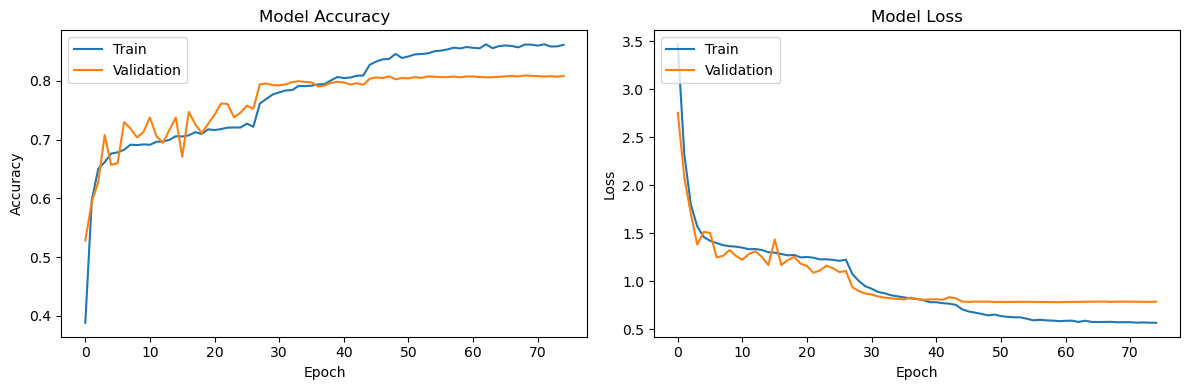

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Add,
    BatchNormalization, Dropout, LeakyReLU, concatenate
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load and preprocess data
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAINFINAL8FEATURESEXTRA_CLEANED.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TESTFINAL8FEATURESEXTRA_CLEANED.xlsx")

# Exclude specific columns
exclude_columns = [#'Onsets',
                    #'Harmonic Mean', 
                    #'Percussive Mean',
                    #'CQT Mean',
                    'Genre',
                    'File Name',
                    'Beat Sync MFCC Mean',
                    'Rhythm Complexity',	
                    #'Tempo',	
                    #'Tempogram Mean'
                    ]
# Extract features and labels, excluding specified columns
X = pd.concat([trainData.drop(columns=exclude_columns), testData.drop(columns=exclude_columns)])
y = pd.concat([trainData['Genre'], testData['Genre']])

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded, num_classes=len(label_encoder.classes_))

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.expand_dims(X_scaled, axis=-1)  # Add channel dimension

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

# Define the Inception module
def inception_module(input_layer, filters):
    conv1 = Conv1D(filters, 1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    
    conv3 = Conv1D(filters, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    
    conv5 = Conv1D(filters, 5, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    
    concat = concatenate([conv1, conv3, conv5], axis=-1)
    return concat

# Define ResNet block
def resnet_block(input_layer, filters, kernel_size=3):
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv1D(filters, 1, padding='same')(input_layer)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([shortcut, x])
    return LeakyReLU(alpha=0.2)(x)

# Model Architecture
input_layer = Input(shape=(X_scaled.shape[1], 1))  # Adjust input shape based on features
x = inception_module(input_layer, 64)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)
x = resnet_block(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)
x = inception_module(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)
x = resnet_block(x, 256)
x = Dropout(0.3)(x)

# Fully Connected Layers
x = GlobalAveragePooling1D()(x)
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

x = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

# Output Layer
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(x)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile with fixed learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Calculate class weights
class_counts = np.sum(y_train, axis=0)
total_samples = np.sum(class_counts)
class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight,
    shuffle=True
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


c:\Users\ashut\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.2903 - loss: 3.9242 - val_accuracy: 0.5092 - val_loss: 2.7517 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.5022 - loss: 2.6224 - val_accuracy: 0.5860 - val_loss: 2.0386 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5471 - loss: 2.0711 - val_accuracy: 0.5220 - val_loss: 1.9414 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5727 - loss: 1.7821 - val_accuracy: 0.5810 - val_loss: 1.6524 - learning_rate: 0.0010
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.5816 - loss: 1.6758 - val_accuracy: 0.5952 - val_loss: 1.5961 - learning_rate: 0.0010
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5849 - loss: 1.6424 - val_accuracy: 0.5534 - val_loss: 1.6761 - learning_rate: 0.0010
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.5

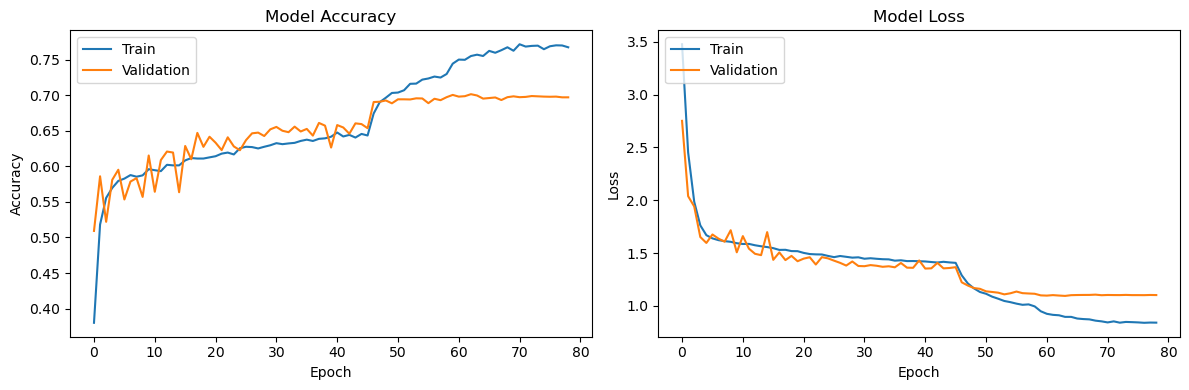

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Add,
    BatchNormalization, Dropout, LeakyReLU, concatenate
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load and preprocess data
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAINFINAL8FEATURESEXTRA_CLEANED.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TESTFINAL8FEATURESEXTRA_CLEANED.xlsx")

# Exclude specific columns
exclude_columns = ['Onsets',
                    'Harmonic Mean', 
                    'Percussive Mean',
                    'CQT Mean',
                    'Genre',
                    'File Name',
                    'Beat Sync MFCC Mean',
                    'Rhythm Complexity',	
                    'Tempo',	
                    'Tempogram Mean'
                    ]
# Extract features and labels, excluding specified columns
X = pd.concat([trainData.drop(columns=exclude_columns), testData.drop(columns=exclude_columns)])
y = pd.concat([trainData['Genre'], testData['Genre']])

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded, num_classes=len(label_encoder.classes_))

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.expand_dims(X_scaled, axis=-1)  # Add channel dimension

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

# Define the Inception module
def inception_module(input_layer, filters):
    conv1 = Conv1D(filters, 1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    
    conv3 = Conv1D(filters, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    
    conv5 = Conv1D(filters, 5, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    
    concat = concatenate([conv1, conv3, conv5], axis=-1)
    return concat

# Define ResNet block
def resnet_block(input_layer, filters, kernel_size=3):
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv1D(filters, 1, padding='same')(input_layer)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([shortcut, x])
    return LeakyReLU(alpha=0.2)(x)

# Model Architecture
input_layer = Input(shape=(X_scaled.shape[1], 1))  # Adjust input shape based on features
x = inception_module(input_layer, 64)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)
x = resnet_block(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)
x = inception_module(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)
x = resnet_block(x, 256)
x = Dropout(0.3)(x)

# Fully Connected Layers
x = GlobalAveragePooling1D()(x)
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

x = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

# Output Layer
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(x)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile with fixed learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Calculate class weights
class_counts = np.sum(y_train, axis=0)
total_samples = np.sum(class_counts)
class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight,
    shuffle=True
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8054 - loss: 0.8041
Test Loss: 0.7837
Test Accuracy: 0.8076
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Classification Report:
              precision    recall  f1-score   support

   AFROHOUSE       0.95      0.96      0.96       500
     AMBIENT       0.86      0.86      0.86       500
   BASSHOUSE       0.79      0.82      0.80       500
   BASSMUSIC       0.65      0.60      0.62       500
     BIGROOM       0.79      0.78      0.78       500
 DRUMANDBASS       0.79      0.87      0.83       500
     DUBSTEP       0.80      0.79      0.79       500
   HARDSTYLE       0.78      0.78      0.78       500
       PHONK       0.82      0.75      0.78       500
   PSYTRANCE       0.84      0.86      0.85       500

    accuracy                           0.81      5000
   macro avg       0.81      0.81      0.81      5000
weighted avg       0.81      0.81      0.81      5000



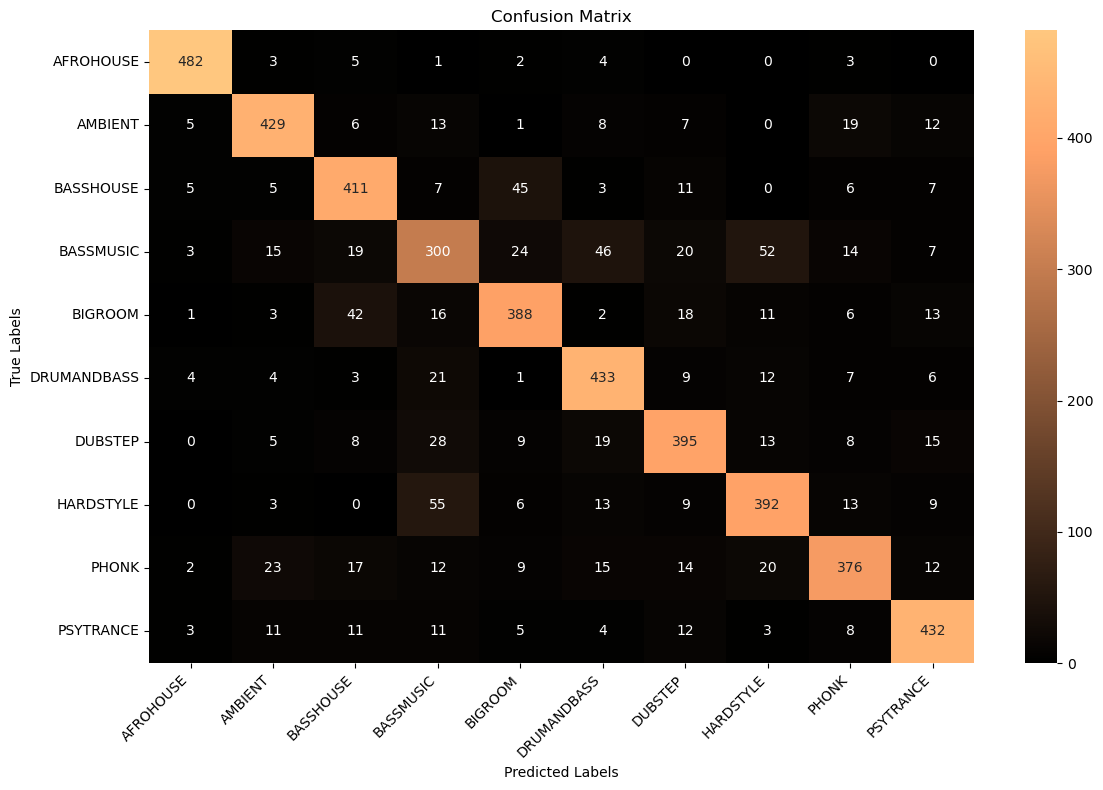

In [28]:
# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Predict and convert predictions to class indices
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plotting the Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(
    conf_matrix, annot=True, fmt='d', cmap='copper', 
    xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [26]:
from tensorflow.keras.utils import plot_model

# Visualize the model structure
plot_model(
    model,
    to_file="model_structure.png",  # Save as an image file
    show_shapes=True,               # Show the shapes of each layer
    show_layer_names=True           # Show the names of each layer
)


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [4]:
pip install pydot


  Using cached pydot-3.0.2-py3-none-any.whl.metadata (10 kB)
Using cached pydot-3.0.2-py3-none-any.whl (35 kB)
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install graphviz

  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)
Note: you may need to restart the kernel to use updated packages.


In [10]:
from tensorflow.keras.utils import plot_model

# Generate the model flow chart
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) for `plot_model` to work.


Epoch 1/100


c:\Users\ashut\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
C:\Users\ashut\AppData\Local\Temp\ipykernel_40036\1751051372.py:140: RuntimeWarning: divide by zero encountered in divide
  class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))


313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.2486 - loss: 2.5052 - val_accuracy: 0.1736 - val_loss: 3.0827 - learning_rate: 0.0010
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.4502 - loss: 1.2624 - val_accuracy: 0.4432 - val_loss: 1.9462 - learning_rate: 0.0010
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.4955 - loss: 0.8093 - val_accuracy: 0.4782 - val_loss: 1.7385 - learning_rate: 0.0010
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5114 - loss: 0.6729 - val_accuracy: 0.4608 - val_loss: 1.7192 - learning_rate: 0.0010
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5119 - loss: 0.6242 - val_accuracy: 0.4922 - val_loss: 1.6217 - learning_rate: 0.0010
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5273 - loss: 0.6031 - val_accuracy: 0.5214 - val_loss: 1.5237 - learning_rate: 0.0010
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5181 - loss: 0.5967

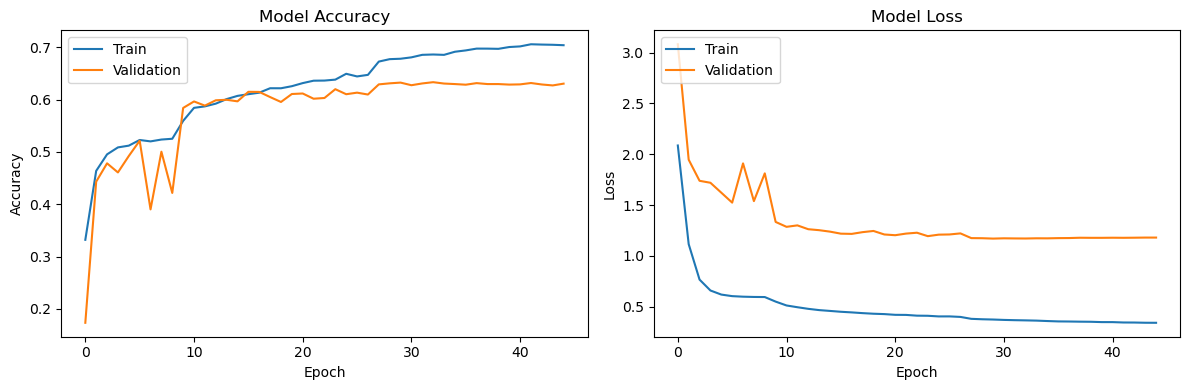

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Add,
    BatchNormalization, Dropout, LeakyReLU, concatenate
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load and preprocess data
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\FinalTRAIN.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\FinalTEST.xlsx")

# Extract features and labels
X = pd.concat([trainData.drop(columns=['Genre', 'File Name']),
               testData.drop(columns=['Genre', 'File Name'])])
y = pd.concat([trainData['Genre'], testData['Genre']])

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Update to one-hot encoding with 30 classes
y_onehot = to_categorical(y_encoded, num_classes=30)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.expand_dims(X_scaled, axis=-1)

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

def inception_module(input_layer, filters):
    # 1x1 convolution
    conv1 = Conv1D(filters, 1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    
    # 3x3 convolution
    conv3 = Conv1D(filters, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    
    # 5x5 convolution
    conv5 = Conv1D(filters, 5, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    
    # Concatenate all branches
    concat = concatenate([conv1, conv3, conv5], axis=-1)
    return concat

def resnet_block(input_layer, filters, kernel_size=3):
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv1D(filters, 1, padding='same')(input_layer)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([shortcut, x])
    return LeakyReLU(alpha=0.2)(x)

# Input Layer
input_layer = Input(shape=(68, 1))

# First Block: Inception Module
x = inception_module(input_layer, 64)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)

# Second Block: ResNet
x = resnet_block(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)

# Third Block: Inception Module
x = inception_module(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)

# Fourth Block: ResNet
x = resnet_block(x, 256)
x = Dropout(0.3)(x)

# Fifth Block: Dense Layers
x = GlobalAveragePooling1D()(x)
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

x = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

# Output Layer
output_layer = Dense(30, activation='softmax')(x)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile with Adam optimizer
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

# Calculate class weights
class_counts = np.sum(y_train, axis=0)
total_samples = np.sum(class_counts)
class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight,
    shuffle=True
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [15]:
!pip install tensorflow
!pip install tensorflow-addons


ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6215 - loss: 1.1866
Test Loss: 1.1697
Test Accuracy: 0.6324
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Classification Report:
              precision    recall  f1-score   support

   AFROHOUSE       0.92      0.94      0.93       500
     AMBIENT       0.76      0.77      0.77       500
   BASSHOUSE       0.69      0.66      0.68       500
   BASSMUSIC       0.46      0.54      0.50       500
     BIGROOM       0.55      0.53      0.54       500
 DRUMANDBASS       0.47      0.34      0.39       500
     DUBSTEP       0.58      0.57      0.57       500
   HARDSTYLE       0.55      0.60      0.58       500
       PHONK       0.75      0.71      0.73       500
   PSYTRANCE       0.58      0.65      0.62       500

    accuracy                           0.63      5000
   macro avg       0.63      0.63      0.63      5000
weighted avg       0.63      0.63      0.63      5000



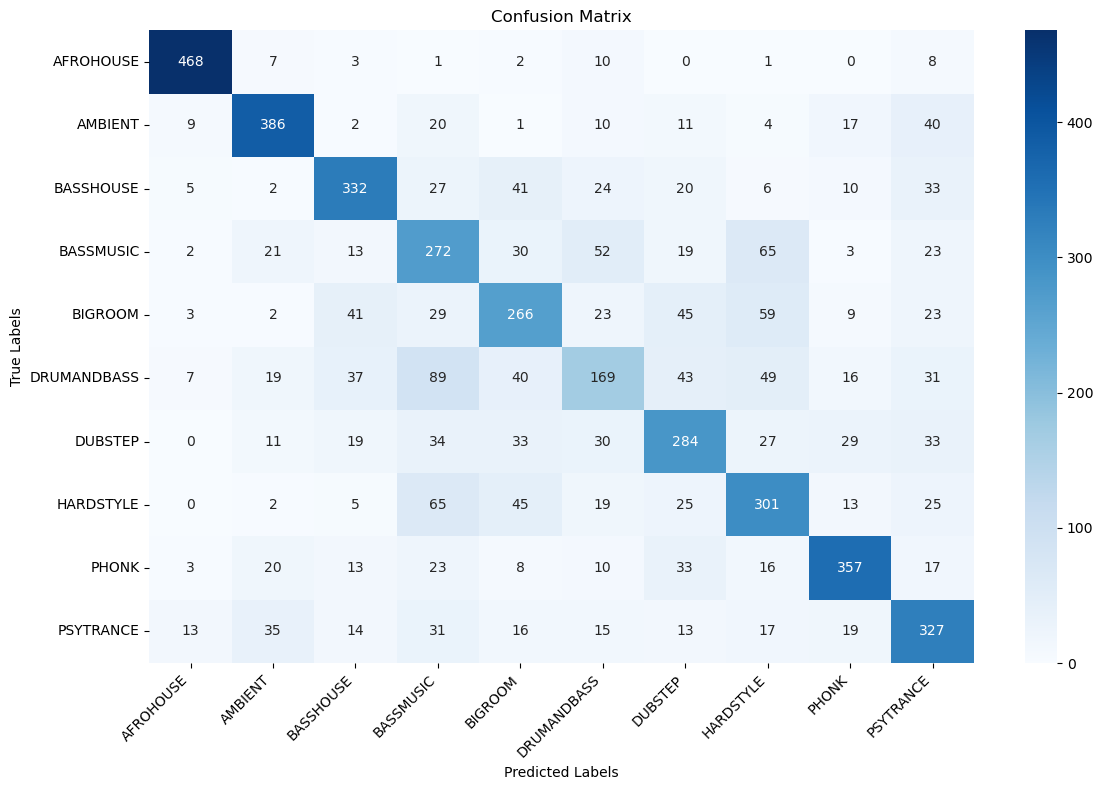

In [17]:
# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Predict and convert predictions to class indices
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plotting the Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(
    conf_matrix, annot=True, fmt='d', cmap='Blues', 
    xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


c:\Users\ashut\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 68, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 68, 64)    │        128 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 68, 64)    │        256 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 68, 64)    │        384 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 68, 64)    │        256 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 68, 64)    │        256 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 68, 64)    │        256 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_12      │ (None, 68, 64)    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_13      │ (None, 68, 64)    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_14      │ (None, 68, 64)    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 68, 192)   │          0 │ leaky_re_lu_12[0… │
│ (Concatenate)       │                   │            │ leaky_re_lu_13[0… │
│                     │                   │            │ leaky_re_lu_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 34, 192)   │          0 │ concatenate_2[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 34, 192)   │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 34, 128)   │     73,856 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 128)   │        512 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_15      │ (None, 34, 128)   │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 34, 128)   │     24,704 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 34, 128)   │     49,280 │ leaky_re_lu_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 128)   │        512 │ conv1d_17[0][0] 

 Total params: 1,165,076 (4.44 MB)

 Trainable params: 1,160,084 (4.43 MB)

 Non-trainable params: 4,992 (19.50 KB)

Epoch 1/100


C:\Users\ashut\AppData\Local\Temp\ipykernel_40036\64201582.py:140: RuntimeWarning: divide by zero encountered in divide
  class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))


625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.2652 - loss: 2.8164 - val_accuracy: 0.4818 - val_loss: 2.3737 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.4560 - loss: 1.4952 - val_accuracy: 0.4474 - val_loss: 1.9606 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.4904 - loss: 1.0704 - val_accuracy: 0.5082 - val_loss: 1.6683 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.4967 - loss: 0.9657 - val_accuracy: 0.3802 - val_loss: 2.0957 - learning_rate: 0.0010
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.4996 - loss: 0.9339 - val_accuracy: 0.4564 - val_loss: 1.7749 - learning_rate: 0.0010
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.5047 - loss: 0.9279 - val_accuracy: 0.4602 - val_loss: 1.8810 - learning_rate: 0.0010
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5025 - loss: 

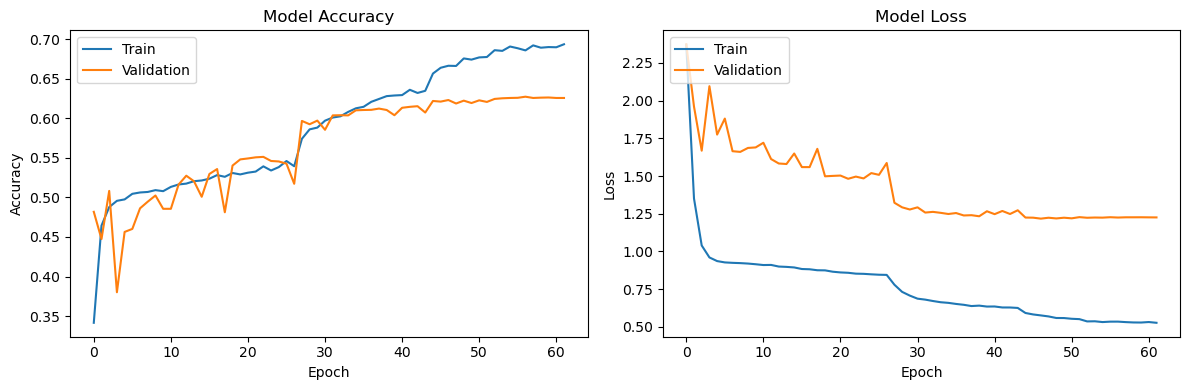

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Add,
    BatchNormalization, Dropout, LeakyReLU, Activation, concatenate
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load and preprocess data
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\FinalTRAIN.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\FinalTEST.xlsx")

# Extract features and labels
X = pd.concat([trainData.drop(columns=['Genre', 'File Name']), testData.drop(columns=['Genre', 'File Name'])])
y = pd.concat([trainData['Genre'], testData['Genre']])

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded, num_classes=20)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.expand_dims(X_scaled, axis=-1)

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

def inception_module(input_layer, filters):
    # 1x1 convolution
    conv1 = Conv1D(filters, 1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    
    # 3x3 convolution
    conv3 = Conv1D(filters, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    
    # 5x5 convolution
    conv5 = Conv1D(filters, 5, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    
    # Concatenate all branches
    concat = concatenate([conv1, conv3, conv5], axis=-1)
    return concat

def resnet_block(input_layer, filters, kernel_size=3):
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv1D(filters, 1, padding='same')(input_layer)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([shortcut, x])
    return LeakyReLU(alpha=0.2)(x)

# Input Layer
input_layer = Input(shape=(68, 1))

# First Block: Inception Module
x = inception_module(input_layer, 64)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)

# Second Block: ResNet
x = resnet_block(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)

# Third Block: Inception Module
x = inception_module(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)

# Fourth Block: ResNet
x = resnet_block(x, 256)
x = Dropout(0.3)(x)

# Fifth Block: Dense Layers
x = GlobalAveragePooling1D()(x)
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

x = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

# Output Layer
output_layer = Dense(20, activation='softmax')(x)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Print model summary
model.summary()

# Compile with fixed learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Calculate class weights
class_counts = np.sum(y_train, axis=0)
total_samples = np.sum(class_counts)
class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight,
    shuffle=True
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


## Using FINALTEST and FINALTRAIN

Epoch 1/150


c:\Users\ashut\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
C:\Users\ashut\AppData\Local\Temp\ipykernel_7412\277056681.py:142: RuntimeWarning: divide by zero encountered in divide
  class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))


625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.2265 - loss: 2.7759 - val_accuracy: 0.3866 - val_loss: 2.5877 - learning_rate: 0.0010
Epoch 2/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.3865 - loss: 1.6042 - val_accuracy: 0.3954 - val_loss: 2.0484 - learning_rate: 0.0010
Epoch 3/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4233 - loss: 1.1688 - val_accuracy: 0.4476 - val_loss: 1.8797 - learning_rate: 0.0010
Epoch 4/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.4235 - loss: 1.0461 - val_accuracy: 0.4412 - val_loss: 1.7582 - learning_rate: 0.0010
Epoch 5/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.4397 - loss: 0.9965 - val_accuracy: 0.4594 - val_loss: 1.7083 - learning_rate: 0.0010
Epoch 6/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.4496 - loss: 0.9748 - val_accuracy: 0.4498 - val_loss: 1.7555 - learning_rate: 0.0010
Epoch 7/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.4521 - loss: 0.9807

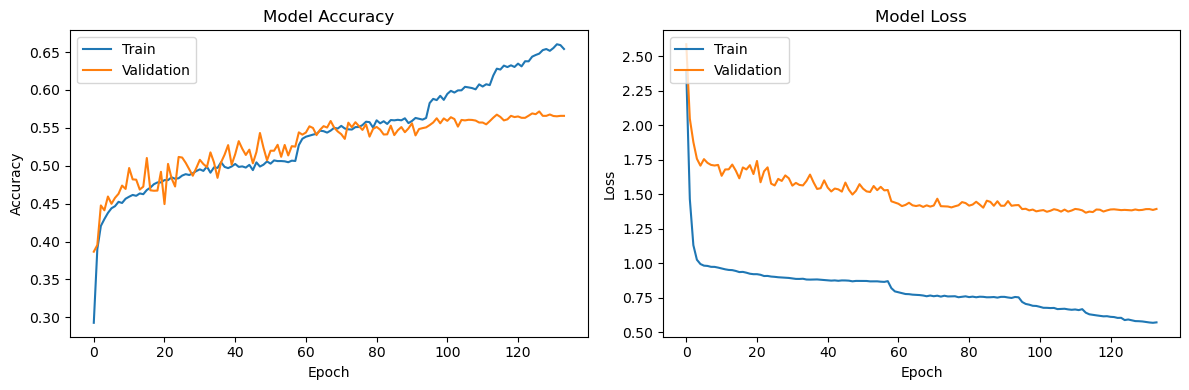

In [ ]:
'''USING PCA AS FEATURE REDUCTION'''

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, 
    Add, BatchNormalization, Dropout, LeakyReLU, concatenate
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# Load data
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\FinalTRAIN.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\FinalTEST.xlsx")

# Extract features and labels
X = pd.concat([
    trainData.drop(columns=['Genre', 'File Name']),
    testData.drop(columns=['Genre', 'File Name'])
])
y = pd.concat([trainData['Genre'], testData['Genre']])

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA with variance threshold
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded, num_classes=20)

# Reshape for 1D convolution
X_pca_reshaped = np.expand_dims(X_pca, axis=-1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_pca_reshaped, y_onehot, test_size=0.2, 
    random_state=42, stratify=y_encoded
)

def advanced_inception_module(input_layer, filters):
    # Multiple convolution branches with different kernel sizes
    conv1 = Conv1D(filters//4, 1, padding='same', kernel_regularizer=l2(0.001))(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.1)(conv1)
    
    conv3 = Conv1D(filters//2, 3, padding='same', kernel_regularizer=l2(0.001))(input_layer)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.1)(conv3)
    
    conv5 = Conv1D(filters//4, 5, padding='same', kernel_regularizer=l2(0.001))(input_layer)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.1)(conv5)
    
    return concatenate([conv1, conv3, conv5], axis=-1)

def residual_block(input_layer, filters):
    # Shortcut path
    shortcut = input_layer
    if input_layer.shape[-1] != filters:  # Check if dimensions match
        shortcut = Conv1D(filters, 1, padding='same', kernel_regularizer=l2(0.001))(shortcut)
    
    # Main path
    x = Conv1D(filters, 3, padding='same', kernel_regularizer=l2(0.001))(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    x = Conv1D(filters, 3, padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    
    # Merge shortcut and main path
    x = Add()([shortcut, x])
    return LeakyReLU(alpha=0.1)(x)

# Model Architecture
input_layer = Input(shape=(X_pca_reshaped.shape[1], 1))

# Enhanced Feature Extraction
x = advanced_inception_module(input_layer, 64)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)

x = residual_block(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.25)(x)

x = advanced_inception_module(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)

x = residual_block(x, 256)
x = GlobalAveragePooling1D()(x)

# Dense Layers with Enhanced Regularization
x = Dense(512, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.4)(x)

x = Dense(256, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.4)(x)

output_layer = Dense(20, activation='softmax')(x)

# Compile Model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=20, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    min_lr=1e-6
)

# Class Weights
class_counts = np.sum(y_train, axis=0)
total_samples = np.sum(class_counts)
class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))

# Training
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight,
    shuffle=True
)

# Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Detailed Metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, 
                            target_names=label_encoder.classes_))

# Visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Epoch 1/200


c:\Users\ashut\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
C:\Users\ashut\AppData\Local\Temp\ipykernel_7412\1676344926.py:151: RuntimeWarning: divide by zero encountered in divide
  class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))


313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.2025 - loss: 10.4649 - val_accuracy: 0.1604 - val_loss: 4.3781 - learning_rate: 0.0010
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.3831 - loss: 2.5714 - val_accuracy: 0.3472 - val_loss: 2.9390 - learning_rate: 0.0010
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.4325 - loss: 1.8878 - val_accuracy: 0.4312 - val_loss: 2.5348 - learning_rate: 0.0010
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.4462 - loss: 1.6442 - val_accuracy: 0.4364 - val_loss: 2.3205 - learning_rate: 0.0010
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.4657 - loss: 1.5125 - val_accuracy: 0.4994 - val_loss: 2.2167 - learning_rate: 0.0010
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.4686 - loss: 1.4969 - val_accuracy: 0.4666 - val_loss: 2.2628 - learning_rate: 0.0010
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.4753 - loss: 1.470

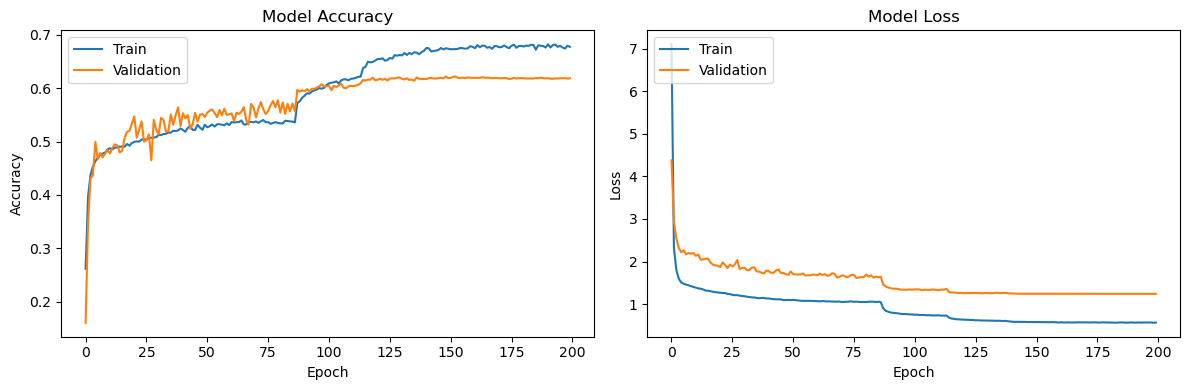

In [12]:
'''
Model check with more accuracy 
if possible



update :- there is need for improvement 
'''


import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Add,
    BatchNormalization, Dropout, LeakyReLU, Activation, concatenate
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
import tensorflow as tf

# Load and preprocess data
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\FinalTRAIN.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\FinalTEST.xlsx")

# Extract features and labels
X = pd.concat([
    trainData.drop(columns=['Genre', 'File Name']),
    testData.drop(columns=['Genre', 'File Name'])
])
y = pd.concat([trainData['Genre'], testData['Genre']])

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded, num_classes=20)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.expand_dims(X_scaled, axis=-1)

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

def inception_module(input_layer, filters):
    # 1x1 convolution
    conv1 = Conv1D(filters, 1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    
    # 3x3 convolution
    conv3 = Conv1D(filters, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    
    # 5x5 convolution
    conv5 = Conv1D(filters, 5, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    
    # Concatenate all branches
    concat = concatenate([conv1, conv3, conv5], axis=-1)
    return concat

def resnet_block(input_layer, filters, kernel_size=3):
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv1D(filters, 1, padding='same')(input_layer)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([shortcut, x])
    return LeakyReLU(alpha=0.2)(x)

# Input Layer
input_layer = Input(shape=(68, 1))

# First Block: Inception Module
x = inception_module(input_layer, 64)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)

# Second Block: ResNet
x = resnet_block(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)

# Third Block: Inception Module
x = inception_module(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.4)(x)

# Fourth Block: ResNet
x = resnet_block(x, 256)
x = Dropout(0.4)(x)

# Fifth Block: Dense Layers
x = GlobalAveragePooling1D()(x)
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.5)(x)

x = Dense(256, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.5)(x)

# Output Layer
output_layer = Dense(20, activation='softmax')(x)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile with AdamW optimizer
model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

# Calculate class weights
class_counts = np.sum(y_train, axis=0)
total_samples = np.sum(class_counts)
class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight,
    shuffle=True
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Conv1D, GlobalAveragePooling1D, LSTM, 
    SimpleRNN, Bidirectional, BatchNormalization, Add, LayerNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MultiHeadAttention, concatenate

# Fix input shape dimensions
def preprocess_data(X):
    return np.expand_dims(X, axis=1)  # Add sequence dimension

# Advanced Inception Model
def advanced_inception_model(input_shape):
    inputs = Input(shape=input_shape)
    conv1 = Conv1D(64, 1, padding='same', activation='relu')(inputs)
    conv3 = Conv1D(64, 3, padding='same', activation='relu')(inputs)
    conv5 = Conv1D(64, 5, padding='same', activation='relu')(inputs)

    x = concatenate([conv1, conv3, conv5])
    x = BatchNormalization()(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(20, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# CNN + ResNet Model
def cnn_resnet_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 3, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    
    shortcut = x
    x = Conv1D(64, 3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Add()([shortcut, x])
    
    x = GlobalAveragePooling1D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(20, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# CNN + LSTM Model
def cnn_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 3, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = LSTM(128, return_sequences=False)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(20, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# RNN + LSTM Model
def rnn_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = SimpleRNN(64, return_sequences=True)(inputs)
    x = LSTM(128, return_sequences=False)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(20, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Transformer Model
def transformer_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(128, activation='relu')(inputs)
    x = LayerNormalization()(x)
    attn_output = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization()(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(20, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Autoencoder + BiLSTM Model
def autoencoder_bilstm_model(input_shape):
    inputs = Input(shape=input_shape)
    encoded = Bidirectional(LSTM(64, return_sequences=True))(inputs)
    encoded = Bidirectional(LSTM(32))(encoded)
    x = Dense(512, activation='relu')(encoded)
    x = Dropout(0.4)(x)
    outputs = Dense(20, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Compile All Models
def compile_all_models(X_train):
    input_shape = X_train.shape[1:]  # Assuming input is 3D after preprocessing
    return {
        'Advanced Inception': advanced_inception_model(input_shape),
        'CNN+ResNet': cnn_resnet_model(input_shape),
        'CNN+LSTM': cnn_lstm_model(input_shape),
        'RNN+LSTM': rnn_lstm_model(input_shape),
        'Transformer': transformer_model(input_shape),
        'Autoencoder+BiLSTM': autoencoder_bilstm_model(input_shape)
    }

# Example Usage
# X_train and X_test are assumed to be your data variables
X_train_1d = preprocess_data(X_train)
X_test_1d = preprocess_data(X_test)

models = compile_all_models(X_train_1d)

# Training example
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train_1d, y_train, epochs=10, batch_size=32, validation_split=0.2)
    print(f"{model_name} training complete.")


c:\Users\ashut\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
C:\Users\ashut\AppData\Local\Temp\ipykernel_23868\2538122805.py:156: RuntimeWarning: divide by zero encountered in divide
  class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))


Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.2077 - loss: 9.2691 - val_accuracy: 0.3718 - val_loss: 3.3820 - learning_rate: 0.0010
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.3846 - loss: 2.2654 - val_accuracy: 0.3772 - val_loss: 2.6877 - learning_rate: 0.0010
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.4245 - loss: 1.7683 - val_accuracy: 0.2876 - val_loss: 3.0981 - learning_rate: 0.0010
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.4196 - loss: 1.6707 - val_accuracy: 0.3862 - val_loss: 2.6851 - learning_rate: 0.0010
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.4346 - loss: 1.6418 - val_accuracy: 0.4200 - val_loss: 2.4795 - learning_rate: 0.0010
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.4306 - loss: 1.6193 - val_accuracy: 0.4326 - val_loss: 2.4240 - learning_rate: 0.0010
Epoch 7/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.4

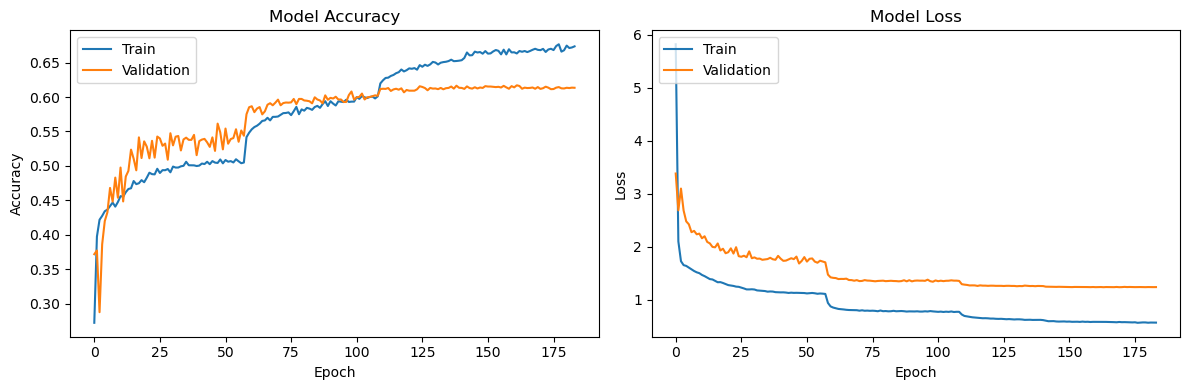

In [1]:
'''  
with the main data of 2000 train and 500 test data 

'''

'''
Model check with more accuracy 
if possible



update :- there is need for improvement 
'''


import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Add,
    BatchNormalization, Dropout, LeakyReLU, Activation, concatenate
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
import tensorflow as tf

# Load and preprocess data
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\FinalTRAIN.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\FinalTEST.xlsx")

# Extract features and labels
X = pd.concat([
    trainData.drop(columns=['Genre', 'File Name']),
    testData.drop(columns=['Genre', 'File Name'])
])
y = pd.concat([trainData['Genre'], testData['Genre']])

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded, num_classes=20)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.expand_dims(X_scaled, axis=-1)

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

def inception_module(input_layer, filters):
    # 1x1 convolution
    conv1 = Conv1D(filters, 1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    
    # 3x3 convolution
    conv3 = Conv1D(filters, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    
    # 5x5 convolution
    conv5 = Conv1D(filters, 5, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    
    # Concatenate all branches
    concat = concatenate([conv1, conv3, conv5], axis=-1)
    return concat

def resnet_block(input_layer, filters, kernel_size=3):
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv1D(filters, 1, padding='same')(input_layer)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([shortcut, x])
    return LeakyReLU(alpha=0.2)(x)

# Input Layer
input_layer = Input(shape=(68, 1))

# First Block: Inception Module
x = inception_module(input_layer, 64)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)

# Second Block: ResNet
x = resnet_block(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)

# Third Block: Inception Module
x = inception_module(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.4)(x)

# Fourth Block: ResNet
x = resnet_block(x, 256)
x = Dropout(0.4)(x)

# Fifth Block: Dense Layers
x = GlobalAveragePooling1D()(x)
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.5)(x)

x = Dense(256, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.5)(x)

# Output Layer
output_layer = Dense(20, activation='softmax')(x)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile with AdamW optimizer
model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

# Calculate class weights
class_counts = np.sum(y_train, axis=0)
total_samples = np.sum(class_counts)
class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight,
    shuffle=True
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Epoch 1/150


c:\Users\ashut\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.0715 - loss: 5.2316 - val_accuracy: 0.0475 - val_loss: 4.5628 - learning_rate: 1.0000e-04
Epoch 2/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0741 - loss: 5.0166 - val_accuracy: 0.0525 - val_loss: 4.6340 - learning_rate: 1.0000e-04
Epoch 3/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0997 - loss: 4.9234 - val_accuracy: 0.0525 - val_loss: 4.7198 - learning_rate: 1.0000e-04
Epoch 4/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0944 - loss: 4.8865 - val_accuracy: 0.0600 - val_loss: 4.7779 - learning_rate: 1.0000e-04
Epoch 5/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1102 - loss: 4.7937 - val_accuracy: 0.0650 - val_loss: 4.7986 - learning_rate: 1.0000e-04
Epoch 6/150
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1116 - loss: 4.7120
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1116 - loss: 4.7

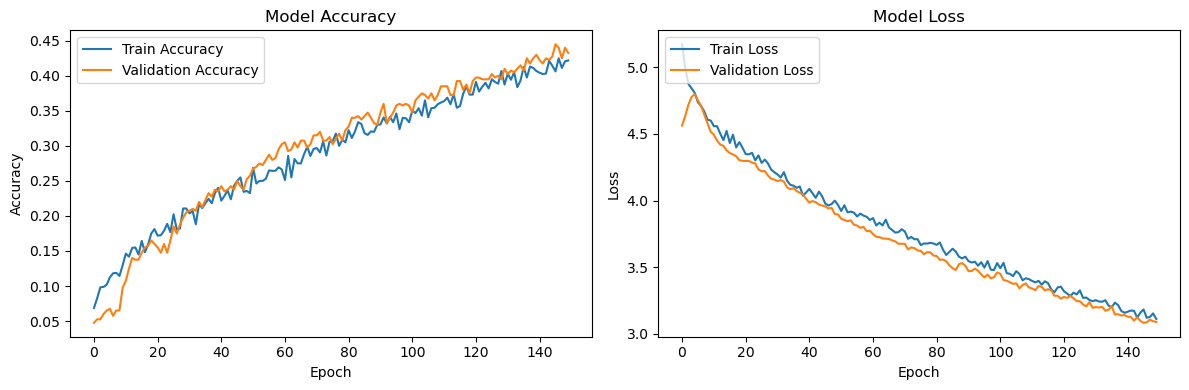

In [13]:
'''
checking other version if possible 


'''

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Add,
    BatchNormalization, Dropout, LeakyReLU, Activation, concatenate
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
import tensorflow as tf

# Load and preprocess data
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAIN.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TEST.xlsx")

# Extract features and labels
X = pd.concat([
    trainData.drop(columns=['Genre', 'File Name']),
    testData.drop(columns=['Genre', 'File Name'])
])
y = pd.concat([trainData['Genre'], testData['Genre']])

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded, num_classes=20)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.expand_dims(X_scaled, axis=-1)

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

def inception_module(input_layer, filters):
    # 1x1 convolution
    conv1 = Conv1D(filters, 1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    
    # 3x3 convolution
    conv3 = Conv1D(filters, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    
    # 5x5 convolution
    conv5 = Conv1D(filters, 5, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    
    # Concatenate all branches
    concat = concatenate([conv1, conv3, conv5], axis=-1)
    return concat

def resnet_block(input_layer, filters):
    x = Conv1D(filters, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(filters, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv1D(filters, 1, padding='same')(input_layer)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([shortcut, x])
    return LeakyReLU(alpha=0.2)(x)

# Input Layer
input_layer = Input(shape=(68, 1))

# First Block: Inception Module
x = inception_module(input_layer, 64)
x = MaxPooling1D(2)(x)
x = Dropout(0.4)(x)  # Increased dropout rate

# Second Block: ResNet
x = resnet_block(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.4)(x)  # Increased dropout rate

# Third Block: Inception Module
x = inception_module(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.4)(x)

# Fourth Block: ResNet
x = resnet_block(x, 256)
x = Dropout(0.4)(x)  # Increased dropout rate

# Fifth Block: Dense Layers
x = GlobalAveragePooling1D()(x)
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)  # Changed to L2 regularization only
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.5)(x)

# Output Layer
output_layer = Dense(20, activation='softmax')(x)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile with AdamW optimizer and a lower learning rate for better convergence
model.compile(
    optimizer=AdamW(learning_rate=1e-4),  # Reduced learning rate for stability
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for dynamic learning rate adjustment and early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1,
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1,
)

# Calculate class weights to handle class imbalance (if any)
class_counts = np.sum(y_train, axis=0) + 1e-6  # Adding a small value to avoid division by zero
total_samples = np.sum(class_counts)
class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))

# Train the model with increased epochs for better learning 
history = model.fit(
    X_train,
    y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight,
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed metrics using classification report and confusion matrix
from sklearn.metrics import classification_report

y_pred_classes = np.argmax(model.predict(X_test), axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes,
                            target_names=label_encoder.classes_))

# Plot training history for accuracy and loss visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Epoch 1/150


c:\Users\ashut\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.0579 - loss: 4.9559 - val_accuracy: 0.0575 - val_loss: 4.2198 - learning_rate: 1.0000e-04
Epoch 2/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0899 - loss: 4.6865 - val_accuracy: 0.0475 - val_loss: 4.2958 - learning_rate: 1.0000e-04
Epoch 3/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0749 - loss: 4.5266 - val_accuracy: 0.0450 - val_loss: 4.4024 - learning_rate: 1.0000e-04
Epoch 4/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1018 - loss: 4.4673 - val_accuracy: 0.0475 - val_loss: 4.4638 - learning_rate: 1.0000e-04
Epoch 5/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1126 - loss: 4.3958 - val_accuracy: 0.0675 - val_loss: 4.4916 - learning_rate: 1.0000e-04
Epoch 6/150
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0851 - loss: 4.3866
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0862 - loss: 4.3

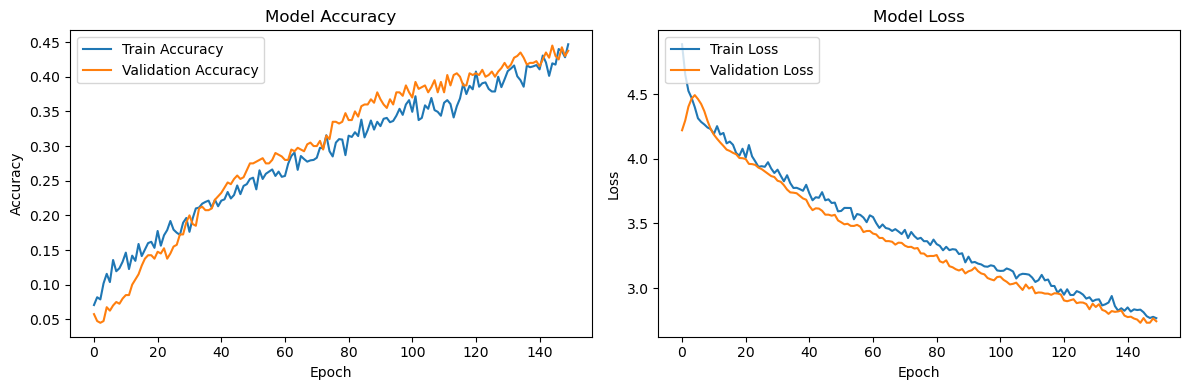

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Add,
    BatchNormalization, Dropout, LeakyReLU, concatenate
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW
import tensorflow as tf
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Load and preprocess data
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAIN.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TEST.xlsx")

# Check for missing values and handle them if necessary
if trainData.isnull().any().any() or testData.isnull().any().any():
    print("Warning: Missing values found in the dataset.")

# Extract features and labels
X = pd.concat([
    trainData.drop(columns=['Genre', 'File Name']),
    testData.drop(columns=['Genre', 'File Name'])
])
y = pd.concat([trainData['Genre'], testData['Genre']])

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded, num_classes=len(label_encoder.classes_))

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.expand_dims(X_scaled, axis=-1)

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

def inception_module(input_layer, filters):
    conv1 = Conv1D(filters, 1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)

    conv3 = Conv1D(filters, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)

    conv5 = Conv1D(filters, 5, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)

    concat = concatenate([conv1, conv3, conv5], axis=-1)
    return concat

def resnet_block(input_layer, filters):
    x = Conv1D(filters, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv1D(filters, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)

    shortcut = Conv1D(filters, 1, padding='same')(input_layer)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([shortcut, x])
    return LeakyReLU(alpha=0.2)(x)

# Input Layer
input_layer = Input(shape=(68, 1))

# Model Architecture
x = inception_module(input_layer, 64)
x = MaxPooling1D(2)(x)
x = Dropout(0.4)(x)

x = resnet_block(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.4)(x)

x = inception_module(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.4)(x)

x = resnet_block(x, 256)
x = Dropout(0.4)(x)

# Dense Layers
x = GlobalAveragePooling1D()(x)
x = Dense(512)(x)  
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)  
x = Dropout(0.5)(x)

# Output Layer
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(x)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with AdamW optimizer and a lower learning rate for better convergence
model.compile(
    optimizer=AdamW(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for dynamic learning rate adjustment and early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1,
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1,
)

model_checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

# Calculate class weights to handle class imbalance (if any)
class_counts = np.sum(y_train > 0, axis=0) + 1e-6 
total_samples = np.sum(class_counts)
class_weight = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}

# Train the model with increased epochs for better learning 
history = model.fit(
    X_train,
    y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr, model_checkpoint_callback],
    class_weight=class_weight,
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed metrics using classification report and confusion matrix
y_pred_classes = np.argmax(model.predict(X_test), axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes,
                            target_names=label_encoder.classes_))

# Plot training history for accuracy and loss visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.1096 - loss: 3.5134 - val_accuracy: 0.0375 - val_loss: 3.0286 - learning_rate: 0.0010
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2968 - loss: 2.4772 - val_accuracy: 0.0063 - val_loss: 3.6981 - learning_rate: 0.0010
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4017 - loss: 1.9190 - val_accuracy: 0.0656 - val_loss: 4.4109 - learning_rate: 0.0010
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5402 - loss: 1.5150 - val_accuracy: 0.0656 - val_loss: 4.2903 - learning_rate: 0.0010
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6110 - loss: 1.2469 - val_accuracy: 0.0469 - val_loss: 4.3658 - learning_rate: 0.0010
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6849 - loss: 0.9912
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6844 - loss: 0.9926 - v

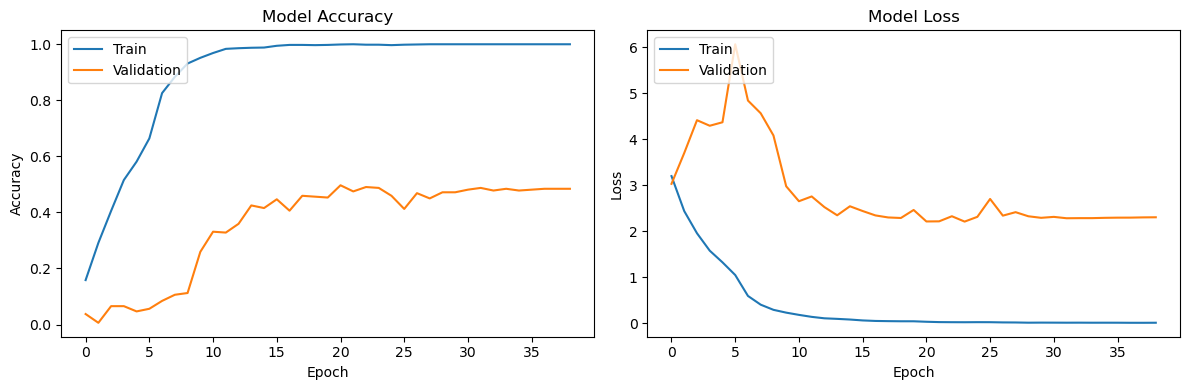

In [19]:
'''
Key changes made to match the architecture in the image:

Removed the Inception modules and simplified to pure ResNet architecture
Implemented the exact sequence of layers shown in Table I:

Conv1D -> Res1D -> MaxPool pattern
Correct filter sizes (128 -> 256 -> 512)
Proper stride values and kernel sizes
Matching output shapes through the network


Added proper residual connections in the Res1D blocks
Removed unnecessary dropout layers to match the architecture
Simplified the final layers to match the table specifications

'''




import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dense, Add,
    BatchNormalization, Dropout, Activation, GlobalAveragePooling1D
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load and preprocess data
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAIN.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TEST.xlsx")

# Extract features and labels
X = pd.concat([
    trainData.drop(columns=['Genre', 'File Name']),
    testData.drop(columns=['Genre', 'File Name'])
])
y = pd.concat([trainData['Genre'], testData['Genre']])

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded, num_classes=20)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.expand_dims(X_scaled, axis=-1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

def res1d_block(input_layer, filters, kernel_size=3, stride=1):
    """
    Implements a Res1D block with adjusted padding
    """
    x = Conv1D(filters, kernel_size, strides=stride, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # If stride > 1 or different number of filters, we need to adjust the shortcut
    if stride > 1 or input_layer.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, strides=stride, padding='same')(input_layer)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input_layer
    
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

# Input Layer
input_layer = Input(shape=(68, 1))

# Initial Conv1D with reduced stride
x = Conv1D(filters=128, kernel_size=3, strides=1, padding='same')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# First block (128 filters)
x = res1d_block(x, filters=128, stride=1)
x = MaxPooling1D(pool_size=2, strides=2)(x)  # Reduced pool size and stride

# Second block (128 filters)
x = res1d_block(x, filters=128, stride=1)
x = MaxPooling1D(pool_size=2, strides=2)(x)

# Third block (256 filters)
x = res1d_block(x, filters=256, stride=1)
x = MaxPooling1D(pool_size=2, strides=2)(x)

# Fourth block (256 filters)
x = res1d_block(x, filters=256, stride=1)
x = MaxPooling1D(pool_size=2, strides=2)(x)

# Fifth block (512 filters)
x = res1d_block(x, filters=512, stride=1)

# Global pooling
x = GlobalAveragePooling1D()(x)

# Final Dense layers
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output Layer
output_layer = Dense(20, activation='softmax')(x)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Calculate class weights
class_counts = np.sum(y_train, axis=0)
total_samples = np.sum(class_counts)
class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight,
    shuffle=True
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dense, Add, Layer,
    BatchNormalization, Dropout, Activation, GlobalAveragePooling1D,
    MultiHeadAttention, LayerNormalization
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Custom Attention Layer
class SqueezeAndExcitation(Layer):
    def __init__(self, ratio=16):
        super().__init__()
        self.ratio = ratio

    def build(self, input_shape):
        filters = input_shape[-1]
        self.squeeze = GlobalAveragePooling1D()
        self.excitation = Dense(filters // self.ratio, activation='relu')
        self.excitation2 = Dense(filters, activation='sigmoid')

    def call(self, inputs):
        x = self.squeeze(inputs)
        x = self.excitation(x)
        x = self.excitation2(x)
        return inputs * tf.expand_dims(x, 1)

def res1d_block_v2(input_layer, filters, kernel_size=3, stride=1, se_ratio=16):
    """
    Enhanced Res1D block with SE-attention and modern techniques
    """
    # First conv block
    x = Conv1D(filters, kernel_size, strides=stride, padding='same',
               kernel_regularizer=l2(1e-4))(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second conv block
    x = Conv1D(filters, kernel_size, padding='same',
               kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    
    # Squeeze-and-Excitation block
    x = SqueezeAndExcitation(ratio=se_ratio)(x)
    
    # Shortcut connection with matching dimensions
    if stride > 1 or input_layer.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, strides=stride, padding='same',
                         kernel_regularizer=l2(1e-4))(input_layer)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input_layer
    
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

# Load and preprocess data
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAIN.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TEST.xlsx")

# Extract features and labels
X = pd.concat([
    trainData.drop(columns=['Genre', 'File Name']),
    testData.drop(columns=['Genre', 'File Name'])
])
y = pd.concat([trainData['Genre'], testData['Genre']])

# Enhanced data preprocessing
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)

# Improved feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.expand_dims(X_scaled, axis=-1)

# Split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

# Model Architecture
input_layer = Input(shape=(68, 1))

# Initial convolution with larger kernel
x = Conv1D(filters=128, kernel_size=7, strides=2, padding='same',
           kernel_regularizer=l2(1e-4))(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

# First stack (128 filters)
for i in range(3):
    x = res1d_block_v2(x, filters=128, stride=1)
x = MaxPooling1D(pool_size=2, strides=2)(x)

# Second stack (256 filters)
for i in range(4):
    x = res1d_block_v2(x, filters=256, stride=1 if i > 0 else 2)
x = MaxPooling1D(pool_size=2, strides=2)(x)

# Third stack (512 filters)
for i in range(3):
    x = res1d_block_v2(x, filters=512, stride=1 if i > 0 else 2)

# Global Context Block
att = MultiHeadAttention(num_heads=4, key_dim=128)(x, x, x)
x = LayerNormalization()(x + att)

# Global Pooling and Head
x = GlobalAveragePooling1D()(x)

# Dense layers with modern regularization
x = Dense(1024, kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)

x = Dense(512, kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)

# Output with label smoothing
output_layer = Dense(20, activation='softmax')(x)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile with modern optimizer
optimizer = AdamW(
    learning_rate=1e-3,
    weight_decay=1e-5,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Enhanced callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.keras',  # Change from 'best_model.h5' to 'best_model.keras'
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Calculate balanced class weights
class_counts = np.sum(y_train, axis=0)
total_samples = np.sum(class_counts)
class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))

# Data augmentation function
def augment_batch(x, y):
    # Random scaling
    scale_factor = np.random.uniform(0.8, 1.2, size=(x.shape[0], 1, 1))
    x_scaled = x * scale_factor
    
    # Random noise
    noise = np.random.normal(0, 0.01, size=x.shape)
    x_noisy = x_scaled + noise
    
    return x_noisy, y

# Custom training loop with augmentation
def train_with_augmentation(model, x_train, y_train, batch_size, epochs, validation_split=0.2):
    n_val = int(len(x_train) * validation_split)
    x_val, y_val = x_train[-n_val:], y_train[-n_val:]
    x_train, y_train = x_train[:-n_val], y_train[:-n_val]
    
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        
        # Training
        for i in range(0, len(x_train), batch_size):
            batch_x = x_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]
            
            # Apply augmentation
            batch_x, batch_y = augment_batch(batch_x, batch_y)
            
            # Train on batch
            metrics = model.train_on_batch(batch_x, batch_y)
            
        # Validation
        val_metrics = model.evaluate(x_val, y_val, verbose=0)
        
        # Update history
        history['loss'].append(metrics[0])
        history['accuracy'].append(metrics[1])
        history['val_loss'].append(val_metrics[0])
        history['val_accuracy'].append(val_metrics[1])
        
        print(f'loss: {metrics[0]:.4f} - accuracy: {metrics[1]:.4f} - val_loss: {val_metrics[0]:.4f} - val_accuracy: {val_metrics[1]:.4f}')
        
    return history

# Train with augmentation
history = train_with_augmentation(
    model,
    X_train,
    y_train,
    batch_size=32,
    epochs=100
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Detailed metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Visualize results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Epoch 1/100


c:\Users\ashut\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


loss: 3.4314 - accuracy: 0.2141 - val_loss: 4.7376 - val_accuracy: 0.0750
Epoch 2/100
loss: 2.9953 - accuracy: 0.3388 - val_loss: 4.5869 - val_accuracy: 0.0500
Epoch 3/100
loss: 2.6271 - accuracy: 0.4387 - val_loss: 4.1932 - val_accuracy: 0.0750
Epoch 4/100


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dense, Add, Layer,
    BatchNormalization, Dropout, Activation, GlobalAveragePooling1D,
    MultiHeadAttention, LayerNormalization
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Custom Attention Layer
class SqueezeAndExcitation(Layer):
    def __init__(self, ratio=16):
        super().__init__()
        self.ratio = ratio

    def build(self, input_shape):
        filters = input_shape[-1]
        self.squeeze = GlobalAveragePooling1D()
        self.excitation = Dense(filters // self.ratio, activation='relu')
        self.excitation2 = Dense(filters, activation='sigmoid')

    def call(self, inputs):
        x = self.squeeze(inputs)
        x = self.excitation(x)
        x = self.excitation2(x)
        return inputs * tf.expand_dims(x, 1)

def res1d_block_v2(input_layer, filters, kernel_size=3, stride=1, se_ratio=16):
    # First conv block
    x = Conv1D(filters, kernel_size, strides=stride, padding='same',
               kernel_regularizer=l2(1e-4))(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second conv block
    x = Conv1D(filters, kernel_size, padding='same',
               kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    
    # Squeeze-and-Excitation block
    x = SqueezeAndExcitation(ratio=se_ratio)(x)
    
    # Shortcut connection
    if stride > 1 or input_layer.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, strides=stride, padding='same',
                         kernel_regularizer=l2(1e-4))(input_layer)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input_layer
    
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

# Load and preprocess data
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAIN.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TEST.xlsx")

# Extract features and labels
X = pd.concat([
    trainData.drop(columns=['Genre', 'File Name']),
    testData.drop(columns=['Genre', 'File Name'])
])
y = pd.concat([trainData['Genre'], testData['Genre']])

# Label encoding and one-hot encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)

# Standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for feature reduction
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)
X_pca = np.expand_dims(X_pca, axis=-1)  # Reshape for Conv1D input

# Split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

# Model Architecture
input_layer = Input(shape=(50, 1))

# Initial convolution
x = Conv1D(filters=128, kernel_size=7, strides=2, padding='same',
           kernel_regularizer=l2(1e-4))(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

# Stacks of Res1D blocks
for i in range(3):
    x = res1d_block_v2(x, filters=128, stride=1)
x = MaxPooling1D(pool_size=2, strides=2)(x)

for i in range(4):
    x = res1d_block_v2(x, filters=256, stride=1 if i > 0 else 2)
x = MaxPooling1D(pool_size=2, strides=2)(x)

for i in range(3):
    x = res1d_block_v2(x, filters=512, stride=1 if i > 0 else 2)

# Global Context Block
att = MultiHeadAttention(num_heads=4, key_dim=128)(x, x, x)
x = LayerNormalization()(x + att)

# Global Pooling and Dense layers
x = GlobalAveragePooling1D()(x)
x = Dense(1024, kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.4)(x)  # Increased Dropout rate
x = Dense(512, kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)  # Increased Dropout rate

# Output layer
output_layer = Dense(20, activation='softmax')(x)

# Compile model
model = Model(inputs=input_layer, outputs=output_layer)
optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-5)  # Reduced learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Enhanced callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Calculate class weights
class_counts = np.sum(y_train, axis=0)
total_samples = np.sum(class_counts)
class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))

# Data augmentation function
def augment_batch(x, y):
    scale_factor = np.random.uniform(0.8, 1.2, size=(x.shape[0], 1, 1))
    x_scaled = x * scale_factor
    noise = np.random.normal(0, 0.01, size=x.shape)
    x_noisy = x_scaled + noise
    return x_noisy, y

# Custom training loop with augmentation
def train_with_augmentation(model, x_train, y_train, batch_size, epochs, validation_split=0.2):
    n_val = int(len(x_train) * validation_split)
    x_val, y_val = x_train[-n_val:], y_train[-n_val:]
    x_train, y_train = x_train[:-n_val], y_train[:-n_val]
    
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        for i in range(0, len(x_train), batch_size):
            batch_x = x_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]
            batch_x, batch_y = augment_batch(batch_x, batch_y)
            metrics = model.train_on_batch(batch_x, batch_y, class_weight=class_weight)
        
        val_metrics = model.evaluate(x_val, y_val, verbose=0)
        history['loss'].append(metrics[0])
        history['accuracy'].append(metrics[1])
        history['val_loss'].append(val_metrics[0])
        history['val_accuracy'].append(val_metrics[1])
        print(f'loss: {metrics[0]:.4f} - accuracy: {metrics[1]:.4f} - val_loss: {val_metrics[0]:.4f} - val_accuracy: {val_metrics[1]:.4f}')
        
    return history

# Train the model
history = train_with_augmentation(
    model, X_train, y_train, batch_size=32, epochs=100
)


Epoch 1/100


c:\Users\ashut\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


loss: 4.1255 - accuracy: 0.0734 - val_loss: 3.9001 - val_accuracy: 0.0562
Epoch 2/100
loss: 3.4168 - accuracy: 0.1831 - val_loss: 4.0238 - val_accuracy: 0.0625
Epoch 3/100
loss: 3.0163 - accuracy: 0.3156 - val_loss: 4.0012 - val_accuracy: 0.0719
Epoch 4/100
loss: 2.6572 - accuracy: 0.4019 - val_loss: 3.9736 - val_accuracy: 0.0656
Epoch 5/100


KeyboardInterrupt: 

In [2]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 25.8 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 36.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.0957 - loss: 3.1463 - val_accuracy: 0.0550 - val_loss: 3.0102 - learning_rate: 0.0010
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2251 - loss: 2.5659 - val_accuracy: 0.0450 - val_loss: 3.3083 - learning_rate: 0.0010
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3058 - loss: 2.1970 - val_accuracy: 0.0500 - val_loss: 4.0500 - learning_rate: 0.0010
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3789 - loss: 1.9466 - val_accuracy: 0.0650 - val_loss: 3.9144 - learning_rate: 0.0010
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4496 - loss: 1.7496 - val_accuracy: 0.1075 - val_loss: 3.7054 - learning_rate: 0.0010
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5207 - loss: 1.5495 - val_accuracy: 0.1950 - val_loss: 2.8745 - learning_rate: 0.0010
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5986 - loss: 1.3040 - 

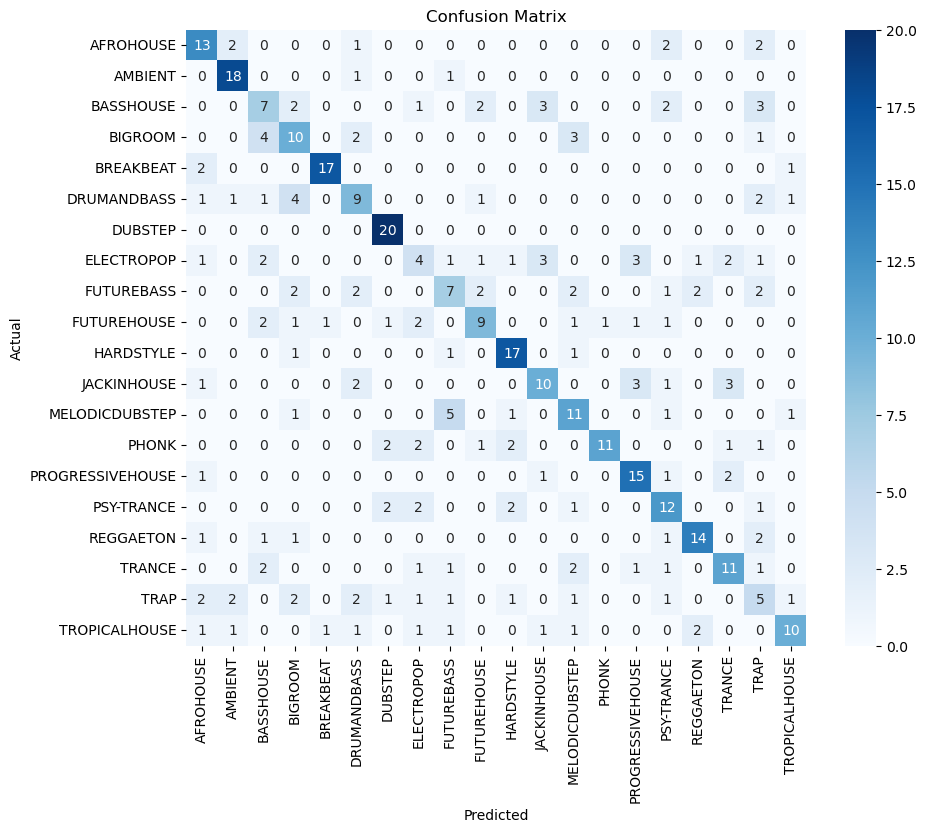

'\n\nWARNING:tensorflow:5 out of the last 5 calls to <function TensorFlowTrainer.make_train_function.<locals>.one_step_on_iterator at 0x17a95e160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.\nWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_train_function.<locals>.one_step_on_iterator at 0x17a95e160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly

In [12]:


'''
Key Changes:
Random Forest Integration:

After training the neural network, the Random Forest model is trained on the flattened input data.
Predictions are made, and accuracy, confusion matrix, and classification report are printed.
Data Preparation for RF:

The input data for the Random Forest model is reshaped to 2D, suitable for training.
Visualization:

Added plots for training and validation accuracy/loss of the ANN.

'''



import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dense, Add,
    BatchNormalization, Dropout, Activation, GlobalAveragePooling1D
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW
import seaborn as sns
import matplotlib.pyplot as plt

# Configuration
CONFIG = {
    'batch_size': 32,
    'epochs': 100,
    'initial_lr': 1e-3,
    'weight_decay': 1e-5,
    'validation_split': 0.2,
    'random_state': 42
}

def create_model(input_shape, num_classes):
    """Create the CNN-ResNet model"""
    inputs = Input(shape=input_shape)
    
    # Initial convolution block
    x = Conv1D(64, kernel_size=3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)
    
    # Residual blocks
    for filters in [128, 256]:
        skip = x
        x = Conv1D(filters, kernel_size=3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv1D(filters, kernel_size=3, padding='same')(x)
        x = BatchNormalization()(x)
        
        if skip.shape[-1] != filters:
            skip = Conv1D(filters, kernel_size=1)(skip)
            skip = BatchNormalization()(skip)
            
        x = Add()([x, skip])
        x = Activation('relu')(x)
        x = MaxPooling1D(2)(x)
    
    # Global pooling and dense layers
    x = GlobalAveragePooling1D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs, outputs)

def load_and_preprocess_data(train_path, test_path):
    """Load and preprocess the dataset"""
    train_data = pd.read_excel(train_path)
    test_data = pd.read_excel(test_path)
    
    # Combine train and test data for encoding/scaling
    X = pd.concat([
        train_data.drop(columns=['Genre', 'File Name']),
        test_data.drop(columns=['Genre', 'File Name'])
    ])
    y = pd.concat([train_data['Genre'], test_data['Genre']])
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = np.expand_dims(X_scaled, axis=-1)
    
    return X_scaled, y_encoded, label_encoder.classes_

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot a confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

def train_model(model, X_train, y_train, X_val, y_val, config):
    """Train the model with error handling and callbacks"""
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6),
        ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
    ]
    
    try:
        history = model.fit(
            X_train, y_train,
            batch_size=config['batch_size'],
            epochs=config['epochs'],
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )
        return history
    except Exception as e:
        print(f"Training failed with error: {str(e)}")
        return None

def main():
    # Load and preprocess data
    X_scaled, y_encoded, class_names = load_and_preprocess_data(
        # '/Users/ashutosh/Documents/GitHub/edm-subgenre-classification/csvs/TRAIN.xlsx',
        # '/Users/ashutosh/Documents/GitHub/edm-subgenre-classification/csvs/TEST.xlsx',
        r'C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAIN.xlsx',
        r'C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TEST.xlsx'
    )
    
    # Convert labels to one-hot encoding
    y_onehot = tf.keras.utils.to_categorical(y_encoded)
    
    # Split data into training and validation sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_onehot,
        test_size=0.2,
        random_state=CONFIG['random_state'],
        stratify=y_encoded
    )
    
    # Create and compile model
    model = create_model(input_shape=(X_train.shape[1], 1), num_classes=len(class_names))
    
    optimizer = AdamW(learning_rate=CONFIG['initial_lr'], weight_decay=CONFIG['weight_decay'])
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train model
    history = train_model(model, X_train, y_train, X_test, y_test, CONFIG)
    
    if history is not None:
        # Evaluate model
        loss, accuracy = model.evaluate(X_test, y_test)
        print(f"\nTest Loss: {loss:.4f}")
        print(f"Test Accuracy: {accuracy:.4f}")
        
        # Train Random Forest for comparison
        rf_model = RandomForestClassifier(n_estimators=100, random_state=CONFIG['random_state'])
        
        # Flatten data for RandomForest
        X_train_rf = X_train.reshape(X_train.shape[0], -1)
        X_test_rf = X_test.reshape(X_test.shape[0], -1)
        y_train_rf = np.argmax(y_train, axis=1)
        y_test_rf = np.argmax(y_test, axis=1)
        
        rf_model.fit(X_train_rf, y_train_rf)
        y_pred_rf = rf_model.predict(X_test_rf)
        
        # Random Forest evaluation
        print("\nRandom Forest Results:")
        print(f"Accuracy: {accuracy_score(y_test_rf, y_pred_rf):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test_rf, y_pred_rf, target_names=class_names))
        
        # Plot confusion matrix for Random Forest
        plot_confusion_matrix(y_test_rf, y_pred_rf, class_names)

if __name__ == "__main__":
    main()

'''

WARNING:tensorflow:5 out of the last 5 calls to <function TensorFlowTrainer.make_train_function.<locals>.one_step_on_iterator at 0x17a95e160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
WARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_train_function.<locals>.one_step_on_iterator at 0x17a95e160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/ashutosh/Library/Python/3.11/lib/python/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
loss: 3.4564 - accuracy: 0.2000 - val_loss: 4.9581 - val_accuracy: 0.0531
Epoch 2/100
loss: 3.1665 - accuracy: 0.3038 - val_loss: 6.0138 - val_accuracy: 0.0719
Epoch 3/100
loss: 3.0970 - accuracy: 0.3844 - val_loss: 5.6372 - val_accuracy: 0.0781
Epoch 4/100
loss: 2.7754 - accuracy: 0.4706 - val_loss: 3.6545 - val_accuracy: 0.2156
Epoch 5/100
loss: 2.1828 - accuracy: 0.5512 - val_loss: 4.4699 - val_accuracy: 0.2375
Epoch 6/100
loss: 2.2839 - accuracy: 0.5875 - val_loss: 3.4896 - val_accuracy: 0.3156
Epoch 7/100


'''

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dense, Add,
    BatchNormalization, Dropout, Activation, GlobalAveragePooling1D
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Lower initial learning rate with Exponential Decay
initial_learning_rate = 5e-4  # Reduced initial learning rate
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train with modified parameters
history = model.fit(
    X_train, y_train,
    epochs=150,  # Increase epochs for better learning
    batch_size=128,  # Higher batch size for stability
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight,
    shuffle=True
)

# Evaluation and plotting code remain the same


# Load and preprocess data (same as before)
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAIN.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TEST.xlsx")

# Data preprocessing (same as before)
X = pd.concat([
    trainData.drop(columns=['Genre', 'File Name']),
    testData.drop(columns=['Genre', 'File Name'])
])
y = pd.concat([trainData['Genre'], testData['Genre']])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded, num_classes=20)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.expand_dims(X_scaled, axis=-1)

# Split data with larger validation set
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

def res1d_block(input_layer, filters, kernel_size=3, stride=1, dropout_rate=0.4):
    """
    Modified Res1D block with increased regularization and dropout
    """
    x = Conv1D(
        filters, 
        kernel_size, 
        strides=stride, 
        padding='same',
        kernel_regularizer=l2(0.02)  # Increased L2 regularization
    )(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)  # Increased dropout
    
    if stride > 1 or input_layer.shape[-1] != filters:
        shortcut = Conv1D(
            filters, 
            1, 
            strides=stride, 
            padding='same',
            kernel_regularizer=l2(0.02)
        )(input_layer)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input_layer
    
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

# Input Layer
input_layer = Input(shape=(68, 1))

# Initial Conv1D with regularization
x = Conv1D(
    filters=128, 
    kernel_size=3, 
    strides=1, 
    padding='same',
    kernel_regularizer=l2(0.02)
)(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.4)(x)  # Increased dropout rate

# Modified architecture with consistent dropout and regularization
x = res1d_block(x, filters=128, stride=1, dropout_rate=0.4)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = res1d_block(x, filters=128, stride=1, dropout_rate=0.4)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = res1d_block(x, filters=256, stride=1, dropout_rate=0.5)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = res1d_block(x, filters=256, stride=1, dropout_rate=0.5)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = res1d_block(x, filters=512, stride=1, dropout_rate=0.6)

# Global pooling
x = GlobalAveragePooling1D()(x)

# Modified Dense layers with increased regularization and dropout
x = Dense(
    512, 
    activation='relu',
    kernel_regularizer=l2(0.02)
)(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)

# Output Layer with regularization
output_layer = Dense(
    20, 
    activation='softmax',
    kernel_regularizer=l2(0.02)
)(x)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Modified compilation with gradient clipping
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-3,
    clipnorm=1.0  # Gradient clipping
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Modified callbacks with reduced patience
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,  # Reduced patience to prevent overfitting
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,  # More aggressive LR reduction
    patience=8,
    min_lr=1e-7,
    verbose=1
)

# Calculate class weights (same as before)
class_counts = np.sum(y_train, axis=0)
total_samples = np.sum(class_counts)
class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))

# Train with modified parameters
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,  # Increased batch size
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight,
    shuffle=True
)

# Evaluation code remains the same
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Prediction and metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Plotting code remains the same
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


NameError: name 'class_weight' is not defined

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, 
    Dense, BatchNormalization, Dropout, Activation, concatenate, Multiply, Reshape
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Load and preprocess data
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAIN.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TEST.xlsx")

# Extract features and labels
X = pd.concat([trainData.drop(columns=['Genre', 'File Name']),
               testData.drop(columns=['Genre', 'File Name'])])
y = pd.concat([trainData['Genre'], testData['Genre']])

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded, num_classes=20)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.expand_dims(X_scaled, axis=-1)

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

# Function to build a CNN model for audio classification
def build_cnn_audio_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    
    # Convolutional Block 1
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)

    # Convolutional Block 2
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)

    # Convolutional Block 3
    x = Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    # Global Pooling Layers
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool])

    # Fully Connected Layers
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.4)(x)

    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.4)(x)

    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Define input shape and number of classes
input_shape = (X_train.shape[1], 1)  # Shape of the features
num_classes = 20  # Number of classes in your dataset

# Build and Compile the Model
model = build_cnn_audio_model(input_shape, num_classes)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks (reused from previous setup)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Calculate class weights
class_counts = np.sum(y_train, axis=0)
total_samples = np.sum(class_counts)
class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr, checkpoint],
    class_weight=class_weight,
    shuffle=True
)


Epoch 1/100
47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0628 - loss: 4.9890
Epoch 1: val_accuracy improved from -inf to 0.06250, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.0631 - loss: 4.9381 - val_accuracy: 0.0625 - val_loss: 3.7030 - learning_rate: 0.0010
Epoch 2/100
42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0766 - loss: 3.7313
Epoch 2: val_accuracy did not improve from 0.06250
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0770 - loss: 3.7213 - val_accuracy: 0.0550 - val_loss: 3.7307 - learning_rate: 0.0010
Epoch 3/100
41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1050 - loss: 3.5472
Epoch 3: val_accuracy did not improve from 0.06250
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1063 - loss: 3.5412 - val_accuracy: 0.0550 - val_loss: 3.8630 - learning_rate: 0.0010
Epoch 4/100
41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1427 - loss: 3.3909
Epoch 4: val_accuracy did not improve from 0.06250
50/